Hyperparameter tune the batch, try Bayesian Search as it is not bruteforce, and does hyperparameter tuning. 

try leakyrelu

softmax all the layers, etc. 

apply L1 + L2 regularization to CNN

dropouts

reduce input size

Show a table for final judgement.

Add some filtering methods

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 64px;"><strong>Assignment 2:</strong></h1>
    <h2 style="color:#7D3C98;">Machine Learning Project</h2>
    <h2 style="color:#7D3C98;"><strong>COSC2673</strong> Machine Learning</h2>
    <h3 style="color:#D2B4DE; margin-top: 24px;">(Undergraduate Level)</h3>
    <h3 style="background: linear-gradient(to right, #7D3C98, #D7BDE2); -webkit-background-clip: text; color: solid;">By Oisin Aeonn & Vince Quach</em></h3>
    <h4 style="color:#BB8FCE;">Student IDs: s3952320 & s3900481</h4>
</div>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">1.0 Table of Contents</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">1.1 Read Me</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">1.2 Introduction</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">1.3 Python Library Imports</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">2.0 Exploratory Data Analysis (EDA)</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">2.1 Data Ingestion</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">2.2 Data Splitting</h3>
    <h4 style="color:#D2B4DE; margin-top: 20px;">2.2-1 Checking for Data Leaks</h4>
    <h3 style="color:#D2B4DE; margin-top: 20px;">Supervised Learning</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">3.0 Using Supervised Non-Neural Network Models (Regression, Tree-Based, & Gradient Boosting)</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">4.0 Baseline Multi-Layer-Perceptron Model</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">5.0 Advanced Modelling using Convolutional Neural Networks</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">6.0 Independent Evaluation and Test</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">6.0 Extending the Convolutional Neural Networks</h3>
    <h6 style="color:#D2B4DE; margin-top: 20px;">NOTE: Complementary Sections are denoted with *</h6>
    <h6 style="color:#D2B4DE; margin-top: 20px;">By default we have hidden these Cells please click the header to see hidden sections.</h6>
</div>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">1.1 Read Me</h1>

<ul style="color:#7D3C98;">
    <li>All tasks were completed in accordance with the Assignment 2 Brief.</li><br>
    <li>The Discussion Forum, Tutorials, and Lectures were all utilised effectively to get as best as an understanding of the assignment requirements as possible. However, there was some ambiguity, and freedom in the way things were phrased. Thus, we tried to have as much fun, and treat this as a real-world problem that would have implications if we got things wrong. E.g. if this system was being used by Tesla Autopilot, and did not classify a stop, giveway, or crossing sign that there may be a risk of physical injury, or death.</li><br> 
    <li>A few sections are marked as Complementary (denoted with *), using methods not allowed, or required in Assignment 2. These were covered for fun, to further improve our models, and for our own personal learning. By default these sections are hidden to ensure you are able to effectively find the core parts of our code for marking.</li><br>
    <li>Predictions are dynamically generated within this Jupyter Notebook, some cells are optional, and running them will lead to different results. Generally run all cells besides those denoted with "⚠" above to see the best expected results.</li><br>
    <li>This project was completed in alignment with RMIT University's Academic Integrity Policy and was solely undertaken by Oisin Aeonn (s3952320) & Vince Quach (s3900481) within the specified timeframe. All materials used are cited, and referenced accordingly.</li><br>
    <li>The project was submitted on-time to the COSC2673 (Undergraduate) Machine Learning Canvas before Monday 9:00AM May 20, 2024.</li><br>
    <li>We are deeply passionate about Machine Learning and aspire to build a career in this field. We are eager for any constructive feedback to enhance our learning and application.</li><br>
    <li>Special thanks to Professor Azadeh Alavi, Dr Pubudu Sanjeevani, and Ms. Rumin Chu (Ph.D) for their invaluable assistance and support in our learning journey.</li><br>
    <li>I hope you enjoy our work!</li><br>
</ul>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">1.2 Introduction</h1>

<h5 style="color:#D2B4DE; margin-top: 20px;">
    <ul>
<li><b>Problem Statement:</b>
<ul>
<br><li>We selected "Project 1: Classify Images of Road Traffic Signs" for our Assessment 2. This Project's goal is to develop an n-ary Classification Model for RoadSigns using a modified version of the BelgiumTS dataset. We will be focusing on creating a generalizable model that can work on an Independently sourced Evaluation Dataset (using similar datasets, as well as collecting locally in the Greater Melbourne Region). In order to achieve this goal we had to understand our training data through conducting the following tasks in order:
<ul>
<li>Extensive EDA</li>
<li>Removal of Bad Data</li>
<li>Ingesting the Training Data</li>
<li>Prepare it for Training by Assigning Labels to the Dataset</li>
<li>Splitting the Data into Training, & Validation</li>
<li>Checking for Leaks in the Datasets</li>
<li>Training Models using different Algorithms, and Techniques</li>
<li>Evaluation using Classification Metrics</li>
<li>Hyperparameter Tuning, and Optimizing Model Performance</li>
<li>Collecting Independent Evaluation Data using the Scientific Method</li>
<li>Testing Generalisability of the Model on our Independently Sourced Evaluation Dataset</li>
</ul>
</li>
<br><li>We will first start by exploring some simple, and less computational intensive techniques such as using the Sigmoid Activation Function in a Logistic Regression Model, and Tree-based Algorithms. Upon finally settling with a baseline model using a Multi-Layer Perceptron (MLP). We will utilize subsequent optimizations found in Convolutional Neural Networks. These optimizations will be pursued through advanced Machine Learning Techniques. Some of these techniques include Hyperparameter Tuning and applying Regularisation. We will also focus on improving our Neural Network Layers. Finally, we will apply some Transfer Learning Techniques. These techniques will help improve our Model further. They will also make the model more generalisable.</li>
</ul>
</li>
        <br><li><b>Dataset:</b>
            <ul>
                <br><li>The analysis is based on a modified version of the BelgiumTS Dataset, encompassing various roadsigns in the European nation state of Belgium.</li>
            </ul>
        </li>
        <br><li><b>Objectives:</b>
            <ul>
                <br><li>Understand the fundamental concepts and algorithms of machine learning and applications.</li>
                <br><li>Understand a range of machine learning methods and the kinds of problem to which they are suited.</li>
                <br><li>Set up a machine learning configuration, including processing data and performing feature engineering, for a range of applications.</li>
                <br><li>Apply machine learning software and toolkits for diverse applications.</li>
                <br><li>Understand the ethical considerations involved in the application of machine learning.</li>
            </ul>
        </li>
        <br><li><b>Scope:</b>
            <ul>
                <br><li>Focus on predicting the correct Roadsign leveraging methods and insights from weeks 1-12 of the COSC2673 Machine Learning Course.</li>
                <br><li>Adopt strategies such as regularization and normalization to refine the model, maintaining the integrity of the feature set.</li>
                <br><li>Strive for the optimal model performance within the established constraints.</li>
                <br><li>Undertake predictions on a separate, unseen dataset (<code>independent_dataset/*</code>) to validate the model's generalisability.</li>
            </ul>
        </li>
    </ul> 
</h5>


<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">1.3 Python Library Imports</h1>

<h5 style="color:#D2B4DE; margin-top: 20px;">
    <ul>
        <li>First, let's cover all of the required imports for this entire Jupyter Notebook.</li><br>
        <li>We put them all here so that you can run most cells (especially EDA, Keras / Tensorflow, and Evaluation) out of order.</li><br>
        <li>This also conforms to the coding standard DO NOT REPEAT YOURSELF (DRY).</li><br>
        <li>We also have provided a commented description of each library for their use.</li>
    </ul>
</h5>

In [3]:
# Tensorflow
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.applications import VGG16, MobileNetV2
from keras.utils import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from keras.applications.resnet import ResNet50

# Numpy
import numpy as np
np.object = np.object_

# Operating system interfaces
import os

# Data manipulation and analysis
import pandas as pd
from pandas.plotting import scatter_matrix
import math

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from imblearn.over_sampling import RandomOverSampler

# Image processing
from PIL import Image
import imageio
from skimage import transform, io, color, filters, measure
from skimage.color import rgb2gray, gray2rgb
from scipy.spatial.distance import euclidean

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Debug
print(os.environ['PATH'])
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

# Plotting style
plt.style.use('dark_background')
%matplotlib inline

/opt/anaconda/bin:/opt/anaconda/condabin:/usr/local/sbin:/usr/local/bin:/usr/bin:/var/lib/flatpak/exports/bin:/usr/lib/jvm/default/bin:/usr/bin/site_perl:/usr/bin/vendor_perl:/usr/bin/core_perl:/var/lib/snapd/snap/bin
Num GPUs Available:  0
[]


<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">2.0 Exploratory Data Analysis (EDA)</h1>

<h5 style="color:#D2B4DE; margin-top: 20px;">
<ul>
<li>Reason for performing EDA:
  <ul>
    <li>To gain insights into the characteristics and properties of the traffic sign images.</li>
    <li>To identify any patterns, trends, or anomalies in the dataset.</li>
    <li>To understand the distribution and variability of different features extracted from the images.</li>
    <li>To assess the quality and consistency of the image data.</li>
    <li>To inform further steps in the analysis or modeling process.</li>
  </ul>
</li>
<br>
<li>What we are looking for:
  <ul>
    <li>Image sizes and formats to ensure consistency and compatibility.</li>
    <li>Image sharpness to identify any blurry or low-quality images.</li>
    <li>Average pixel intensity to understand the overall brightness or darkness of the images.</li>
    <li>Image entropy to measure the amount of information or complexity in the images.</li>
    <li>Image similarities to identify duplicate or highly similar images.</li>
    <li>Domain-specific features (e.g., shape, color) relevant to traffic sign classification.</li>
  </ul>
</li>
</ul>
</h5>

In [4]:
# Directory containing the image dataset
dataset_path = 'trafficsigns_dataset'

# Function to get all image files in subdirectories
def get_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png')):
                image_files.append(os.path.join(root, file))
    return image_files

# Get the list of image files
image_files = get_image_files(dataset_path)

print("Number of image files found:", len(image_files))

# Initialize lists to store image properties
image_sizes = []
image_formats = []
image_sharpness = []
pixel_intensities = []
entropies = []
image_similarities = []
image_data = []

# Iterate over the image files
for image_path in image_files:
    try:
        image = io.imread(image_path, as_gray=True)
        
        # Get image size
        height, width = image.shape
        image_sizes.append((width, height))
        
        # Get image format
        image_format = os.path.splitext(image_path)[1][1:]
        image_formats.append(image_format)
        
        # Calculate image sharpness using the variance of the Laplacian
        sharpness = np.var(filters.laplace(image))
        image_sharpness.append(sharpness)
        
        # Calculate average pixel intensity
        pixel_intensity = np.mean(image)
        pixel_intensities.append(pixel_intensity)
        
        # Calculate image entropy
        entropy = measure.shannon_entropy(image)
        entropies.append(entropy)
        
        # Store image data for similarity calculation
        image_data.append(image.flatten())
        
        # Domain-specific analysis for road sign classification/shape
        # Example: Extract shape features using Hu moments
        moments = measure.moments_hu(image)
        # Perform further analysis or classification based on the extracted features
        
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")

# Calculate image similarities
for i, img1 in enumerate(image_data):
    if i == 0:
        image_similarities.append(0)
    else:
        distances = [euclidean(img1, img2) for img2 in image_data[:i]]
        image_similarities.append(np.min(distances))

Number of image files found: 3699


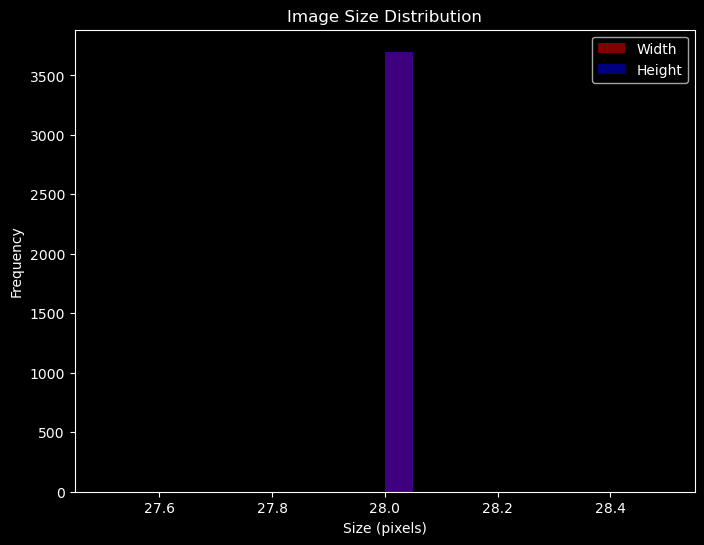

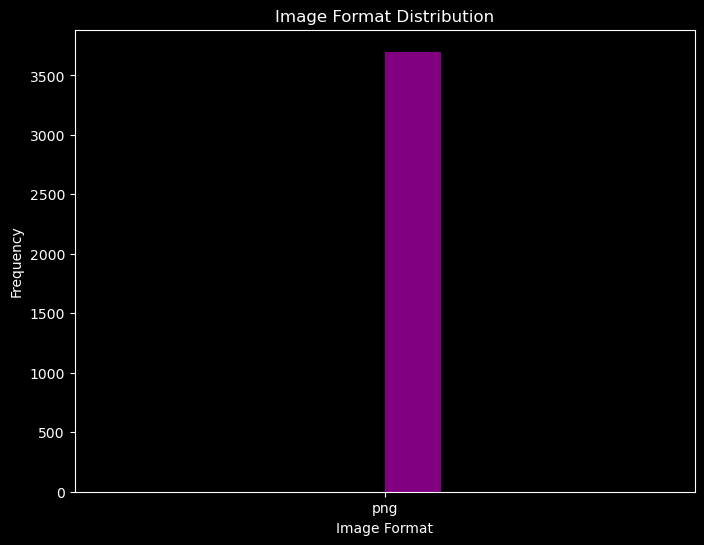

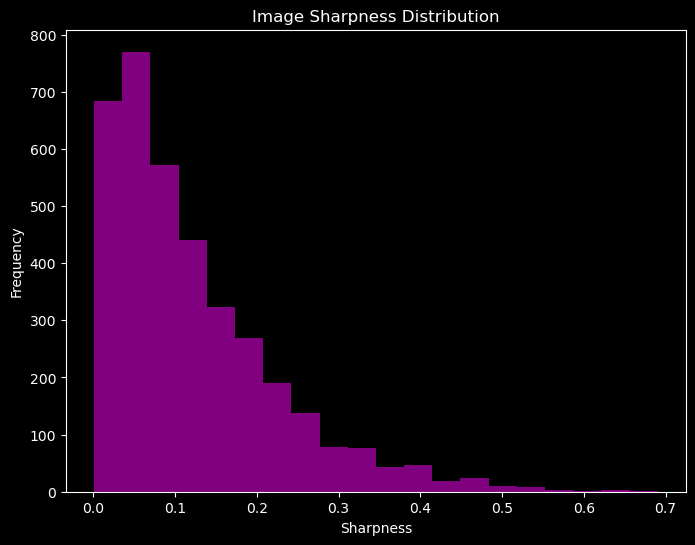

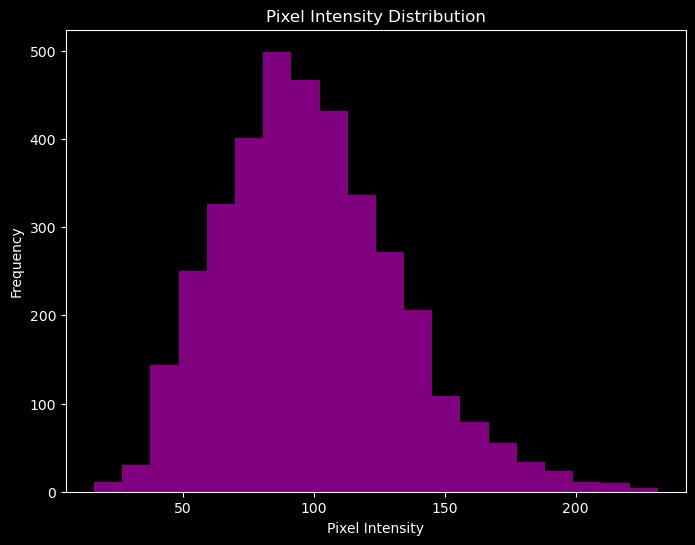

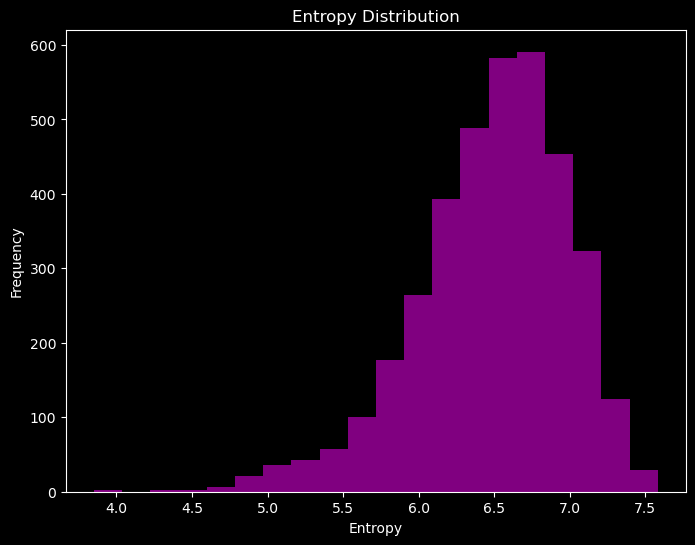

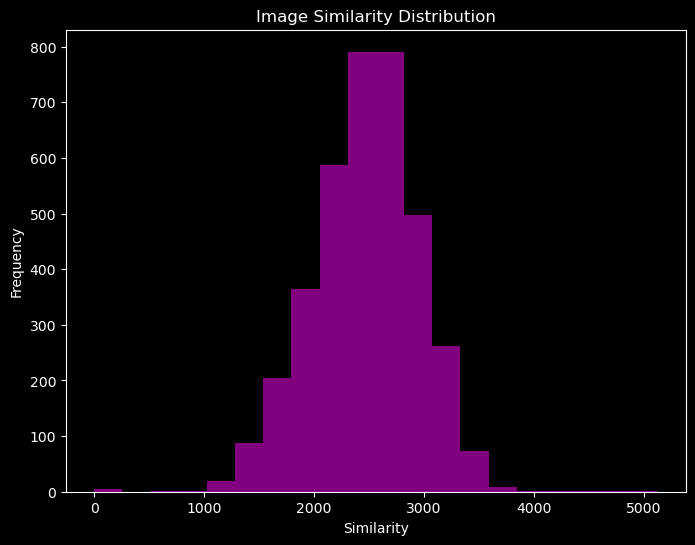

In [5]:
# Plot image size distribution
plt.figure(figsize=(8, 6))
plt.hist([size[0] for size in image_sizes], bins=20, alpha=0.5, color='red', label='Width')
plt.hist([size[1] for size in image_sizes], bins=20, alpha=0.5, color='blue', label='Height')
plt.xlabel('Size (pixels)')
plt.ylabel('Frequency')
plt.title('Image Size Distribution')
plt.legend()
plt.show()

# Plot image format distribution
plt.figure(figsize=(8, 6))
plt.hist(image_formats, color='purple')
plt.xlabel('Image Format')
plt.ylabel('Frequency')
plt.title('Image Format Distribution')
plt.show()

# Plot image sharpness distribution
plt.figure(figsize=(8, 6))
plt.hist(image_sharpness, bins=20, color='purple')
plt.xlabel('Sharpness')
plt.ylabel('Frequency')
plt.title('Image Sharpness Distribution')
plt.show()

# Plot pixel intensity distribution
plt.figure(figsize=(8, 6))
plt.hist(pixel_intensities, bins=20, color='purple')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()

# Plot entropy distribution
plt.figure(figsize=(8, 6))
plt.hist(entropies, bins=20, color='purple')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Entropy Distribution')
plt.show()

# Plot image similarity distribution
plt.figure(figsize=(8, 6))
plt.hist(image_similarities, bins=20, color='purple')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Image Similarity Distribution')
plt.show()

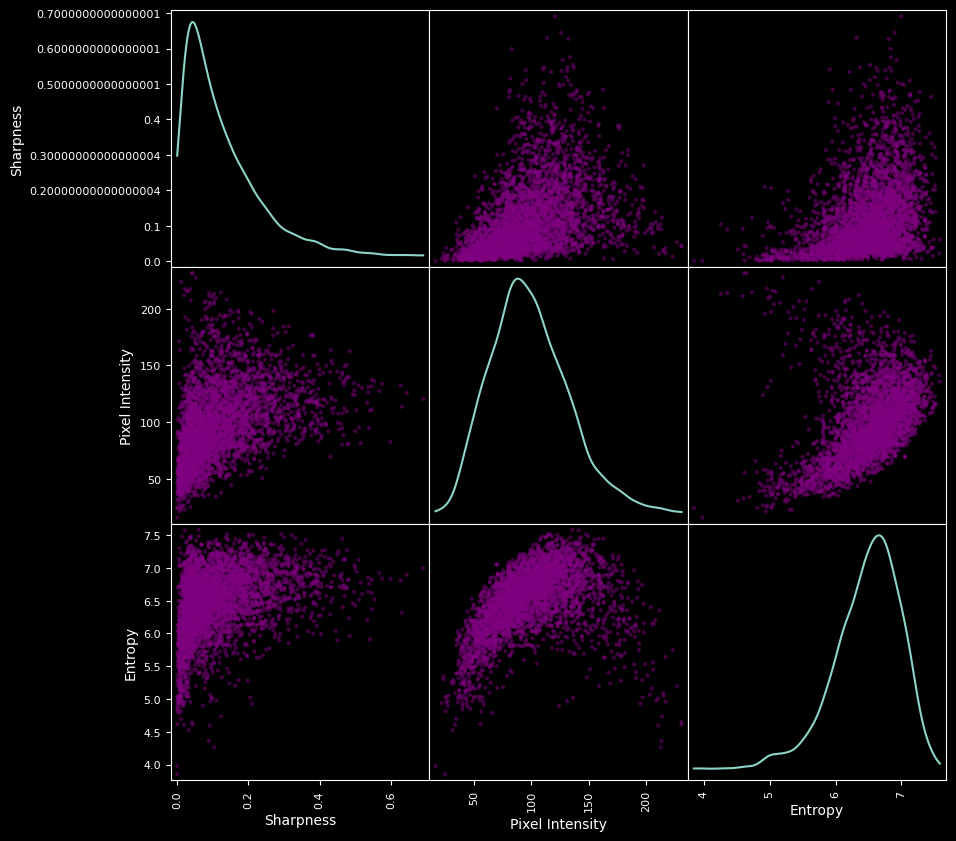

In [6]:
image_properties = pd.DataFrame({
    'Sharpness': image_sharpness,
    'Pixel Intensity': pixel_intensities,
    'Entropy': entropies
})

scatter_matrix(image_properties, figsize=(10, 10), diagonal='kde', color="purple")
plt.show()

<h5 style="color:#D2B4DE; margin-top: 20px;"> <ul> <li>Sharpness: <ul> <li>The distribution of image sharpness is positively skewed.</li> <li>This indicates that the majority of the images have lower sharpness values, with a few outliers having higher sharpness.</li> </ul> </li> <br> <li>Pixel Intensity and Image Similarity: <ul> <li>Both pixel intensity and image similarity follow a roughly Gaussian (bell-shaped) distribution.</li> <li>This suggests that the pixel intensities and image similarities are normally distributed around a central value.</li> </ul> </li> <br> <li>Entropy: <ul> <li>The distribution of image entropy is negatively skewed.</li> <li>This implies that most of the images have higher entropy values, with a few images having lower entropy.</li> </ul> </li> <br> <li>Image Size and Format: <ul> <li>All the images in the dataset have a consistent size of 28x28 pixels.</li> <li>The images are stored in the PNG format, ensuring lossless compression and maintaining image quality.</li> </ul> </li> </ul> </h5>


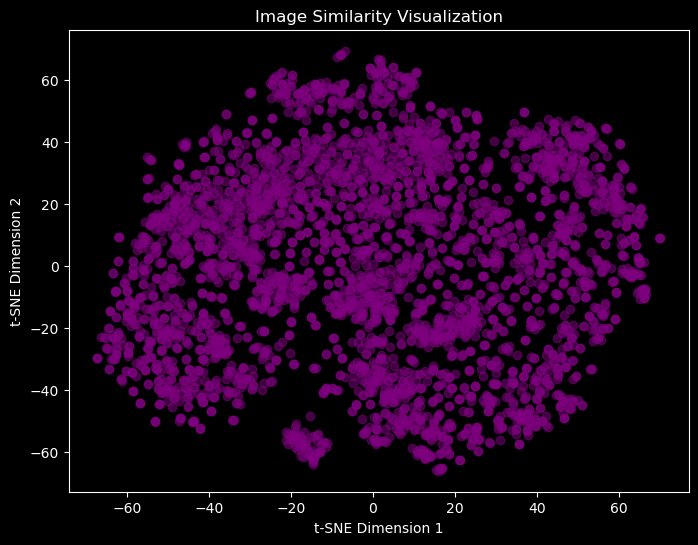

In [7]:
# Convert image_data list to a NumPy array
image_data_array = np.array(image_data)

tsne = TSNE(n_components=2, random_state=42)
image_embeddings = tsne.fit_transform(image_data_array)

plt.figure(figsize=(8, 6))
plt.scatter(image_embeddings[:, 0], image_embeddings[:, 1], alpha=0.5, color='purple')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Image Similarity Visualization')
plt.show()

<h5 style="color:#D2B4DE; margin-top: 20px;">
<span style="font-size:1.5em;">🖼️</span> Image Similarity and Pre-Augmentation:

<span style="font-size:1em;">✔</span> Dataset Diversity:

<ul>
<li>The chart above demonstrates a significant level of diversity within our dataset. This diversity is a strong indicator that the dataset has already undergone pre-augmentation techniques.</li>
</ul>

<span style="font-size:1em;">✔</span> Importance of Pre-Augmentation:

<ul>
<li>Pre-augmentation plays a crucial role in preparing the dataset for training and validation. When a dataset is pre-augmented, it means that various transformations and modifications have already been applied to the images to increase their variability and robustness.</li>
<li>The presence of pre-augmentation suggests that further augmenting the dataset may not be necessary and could potentially introduce errors or biases in the training and validation process.</li>
</ul>

<span style="font-size:1em;">✔</span> Dataset Constraints:

<ul>
<li>The fact that we were instructed not to add or augment the dataset further reinforces the notion that the dataset has been carefully curated and pre-augmented to meet the specific requirements of our task.</li>
<li>However, it's important to note that having a pre-augmented dataset does not necessarily imply that the entire dataset is required for training and validation. In the next step, we will explore techniques to select a subset of the dataset that maximizes performance while minimizing computational resources.</li>
</ul>
</h5>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">2.2 Removing Bad Data</h1>

<h5 style="color:#D2B4DE; margin-top: 20px;">
<ul>
<li>Importance of removing bad training data:
<ul>
<li>Low-quality, inconsistent, or mislabeled data can introduce noise and bias.</li>
<li>Removing bad data can lead to improved model performance.</li>
</ul>
</li>
<br>
<li>Consistency across different types/shapes of samples:
<ul>
<li>Some types or shapes of traffic signs have hard-to-distinguish examples, while others do not.</li>
<li>Having edge cases from only certain types/shapes may create inconsistency in the dataset.</li>
</ul>
</li>
<br>
<li>Impact on independent evaluation data:
<ul>
<li>Purposefully including bad data in the evaluation set can help assess the model's performance on challenging real-world examples.</li>
<li>If edge cases are removed from certain types/shapes during training, the model may struggle with similar examples in the evaluation set. However, having only edge cases for certain road sign shapes / types may lead to unseen test data that is an edge case misclassified due to this inconsistency.</li>
</ul>
</li>
<br>
<li>Balancing data quality and consistency:
<ul>
<li>Removed identified edge cases from the dataset.</li>
<li>Created a benchmark comparing the model's performance on the original dataset versus the cleaned dataset.</li>
<li>Tested the performance increase resulting from removing edge cases while maintaining consistency across all types/shapes of traffic signs.</li>
</ul>
</li>
</ul>
</h5>

In [6]:
LDA

NameError: name 'LDA' is not defined

<h5 style="color:#D2B4DE; margin-top: 20px;">
<ul>
<li>Linear Discriminant Analysis (LDA):
<ul>
<li>Dimensionality reduction technique that maximizes class separability.</li>
<li>Suggested by papers on similar topics for feature extraction and classification.</li>
</ul>
</li>
<br>
<li>Experimentation with LDA:
<ul>
<li>Implemented and evaluated LDA on our traffic sign dataset.</li>
<li>Found LDA to be ineffective for our specific task.</li>
</ul>
</li>
<br>
<li>Decision to explore alternative techniques:
<ul>
<li>Focused on methods that better capture complex patterns and variability.</li>
<li>Aimed to improve classification performance and robustness.</li>
</ul>
</li>
</ul>
</h5>

In [ ]:
Images whilst ours are small add a large amount of dimension to our data. We will later on apply PCA techniques to reduce the size of our dataset, as seen in some of the images the corners are not apart of the signs, and for many types of signs some parts are not relevant. 

In [ ]:
PCA

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">2.3 Data Ingestion</h1>

In [8]:
# Define the size of the images
img_size = (28, 28)

# Set the path to your dataset
dataset_path = 'trafficsigns_dataset'

# Create lists to store the image paths, shapes, and types
image_paths = []
shapes = []
types = []

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">2.3-1 Custom Data Labelling Function</h1>

In [9]:
# Custom Data Labelling Function
for shape in os.listdir(dataset_path):
    shape_path = os.path.join(dataset_path, shape)
    for sign_type in os.listdir(shape_path):
        type_path = os.path.join(shape_path, sign_type)
        for image_file in os.listdir(type_path):
            image_path = os.path.join(type_path, image_file)
            image_paths.append(image_path)
            shapes.append(shape)
            types.append(sign_type)

# Encode the shape and type labels
shape_encoder = LabelEncoder()
type_encoder = LabelEncoder()

shape_labels = shape_encoder.fit_transform(shapes)
type_labels = type_encoder.fit_transform(types)

# Create a DataFrame with image paths, shape labels, and type labels
df = pd.DataFrame({
    'image_path': image_paths,
    'shape_label': shape_labels,
    'type_label': type_labels
})

In [9]:
# Print the first 3 rows of the DataFrame
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   3699 non-null   object
 1   shape_label  3699 non-null   int64 
 2   type_label   3699 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 86.8+ KB


,image_path,shape_label,type_label
0,trafficsigns_dataset/hex/stop/00684_00002.png,1,12
1,trafficsigns_dataset/hex/stop/00685_00002.png,1,12
2,trafficsigns_dataset/hex/stop/00478_00001.png,1,12


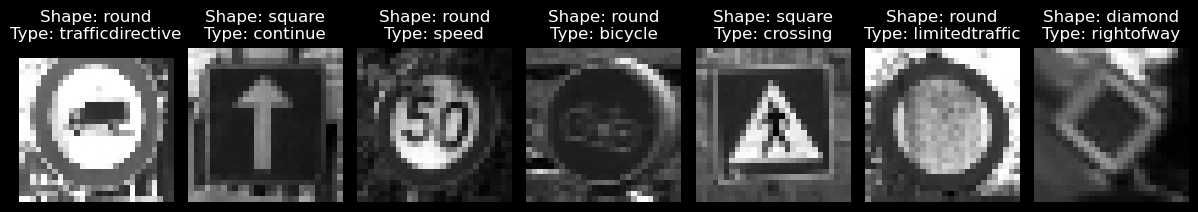

In [10]:
num_images = 7
random_indices = df.index.to_series().sample(num_images)
fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

for i, idx in enumerate(random_indices):
    image_path = df.loc[idx, 'image_path']
    shape_label = shape_encoder.inverse_transform([df.loc[idx, 'shape_label']])[0]
    type_label = type_encoder.inverse_transform([df.loc[idx, 'type_label']])[0]
    image = Image.open(image_path)
    axes[i].imshow(image, cmap='gray')  # Specify cmap='gray' for grayscale images
    axes[i].set_title(f"Shape: {shape_label}\nType: {type_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

<li><b>Dataset Labelling:</b>
<ul>
<br><li>As seen, we have successfully labelled our entire training dataset:
<ul>
<li>∀ I ∈ D<sub>train</sub>, ∃ L<sub>shape</sub>(I) ∧ L<sub>type</sub>(I)</li>
<li>where D<sub>train</sub> is the training dataset, I is an image, and L<sub>shape</sub>(I) and L<sub>type</sub>(I) are the corresponding shape and type labels for image I</li>
</ul>
</li>
<br><li>After further exploring the dataframe, all images seem to be classified correctly. This means we can continue with doing supervised learning to train a supervised model using algorithms taught in the course.</li>
</ul>
</li>

In [11]:
# Check if there are any duplicated rows in the DataFrame
has_duplicates = df.duplicated().any()

# Print out the result
print(f"DuplicateData: {has_duplicates}")

DuplicateData: False


<li><b>Dataset Uniqueness:</b>
<ul>
<br><li>As seen in our dataset, there does not exist any image that is the same as another image:
<ul>
<li>∀ i, j ∈ D, i ≠ j ⟹ I<sub>i</sub> ≠ I<sub>j</sub></li>
<li>where D is the dataset, i and j are distinct indices, and I<sub>i</sub> and I<sub>j</sub> are the corresponding images</li>
</ul>
</li>
<br><li>NOTE: This does not account for slight augmentations. This was explored in the similarity score.</li>
</ul>
</li>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.3-2 EDA (Part 2)</h1>

<li><b>Exploring Data Variability:</b>
<ul>
<br><li>Below we will explore a bit more about the data as we can now explore the variability on shape, and type for our dataset.</li>
</ul>
</li>

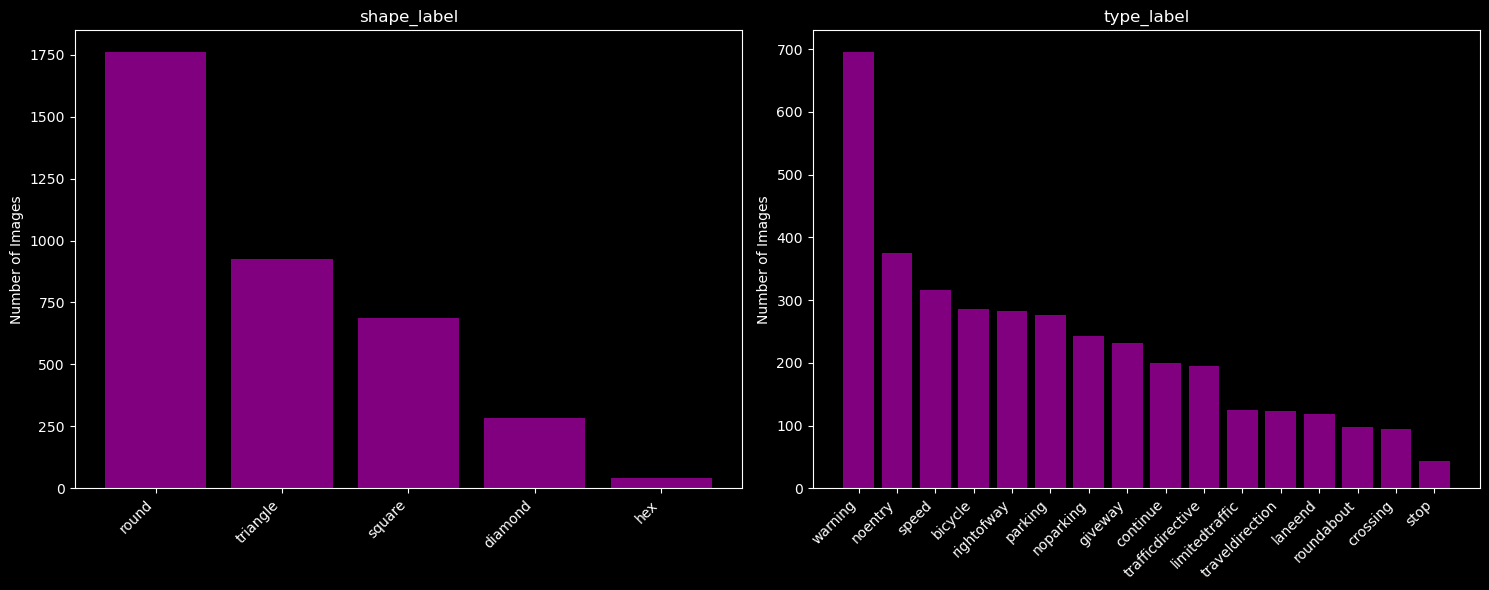

In [12]:
# Get the unique labels for each column
shape_labels = shape_encoder.classes_
type_labels = type_encoder.classes_

# Create a grid of subplots
plt.figure(figsize=(15, 6))

for i, col in enumerate(['shape_label', 'type_label']):
    plt.subplot(1, 2, i+1)
    
    # Get the value counts for the current column
    value_counts = df[col].value_counts()
    
    # Get the actual label names using the inverse transform of the encoders
    if col == 'shape_label':
        label_names = shape_encoder.inverse_transform(value_counts.index)
    else:
        label_names = type_encoder.inverse_transform(value_counts.index)
    
    # Plot the value counts as bars
    plt.bar(range(len(label_names)), value_counts, color='purple')    
    plt.title(col)
    plt.xticks(range(len(label_names)), label_names, rotation=45, ha='right')
    plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

Shape: diamond
rightofway: 282

Shape: hex
stop: 43

Shape: round
noentry: 375
speed: 316
bicycle: 285
noparking: 242
trafficdirective: 195
limitedtraffic: 125
traveldirection: 124
roundabout: 98

Shape: square
parking: 276
continue: 199
laneend: 118
crossing: 95

Shape: triangle
giveway: 231



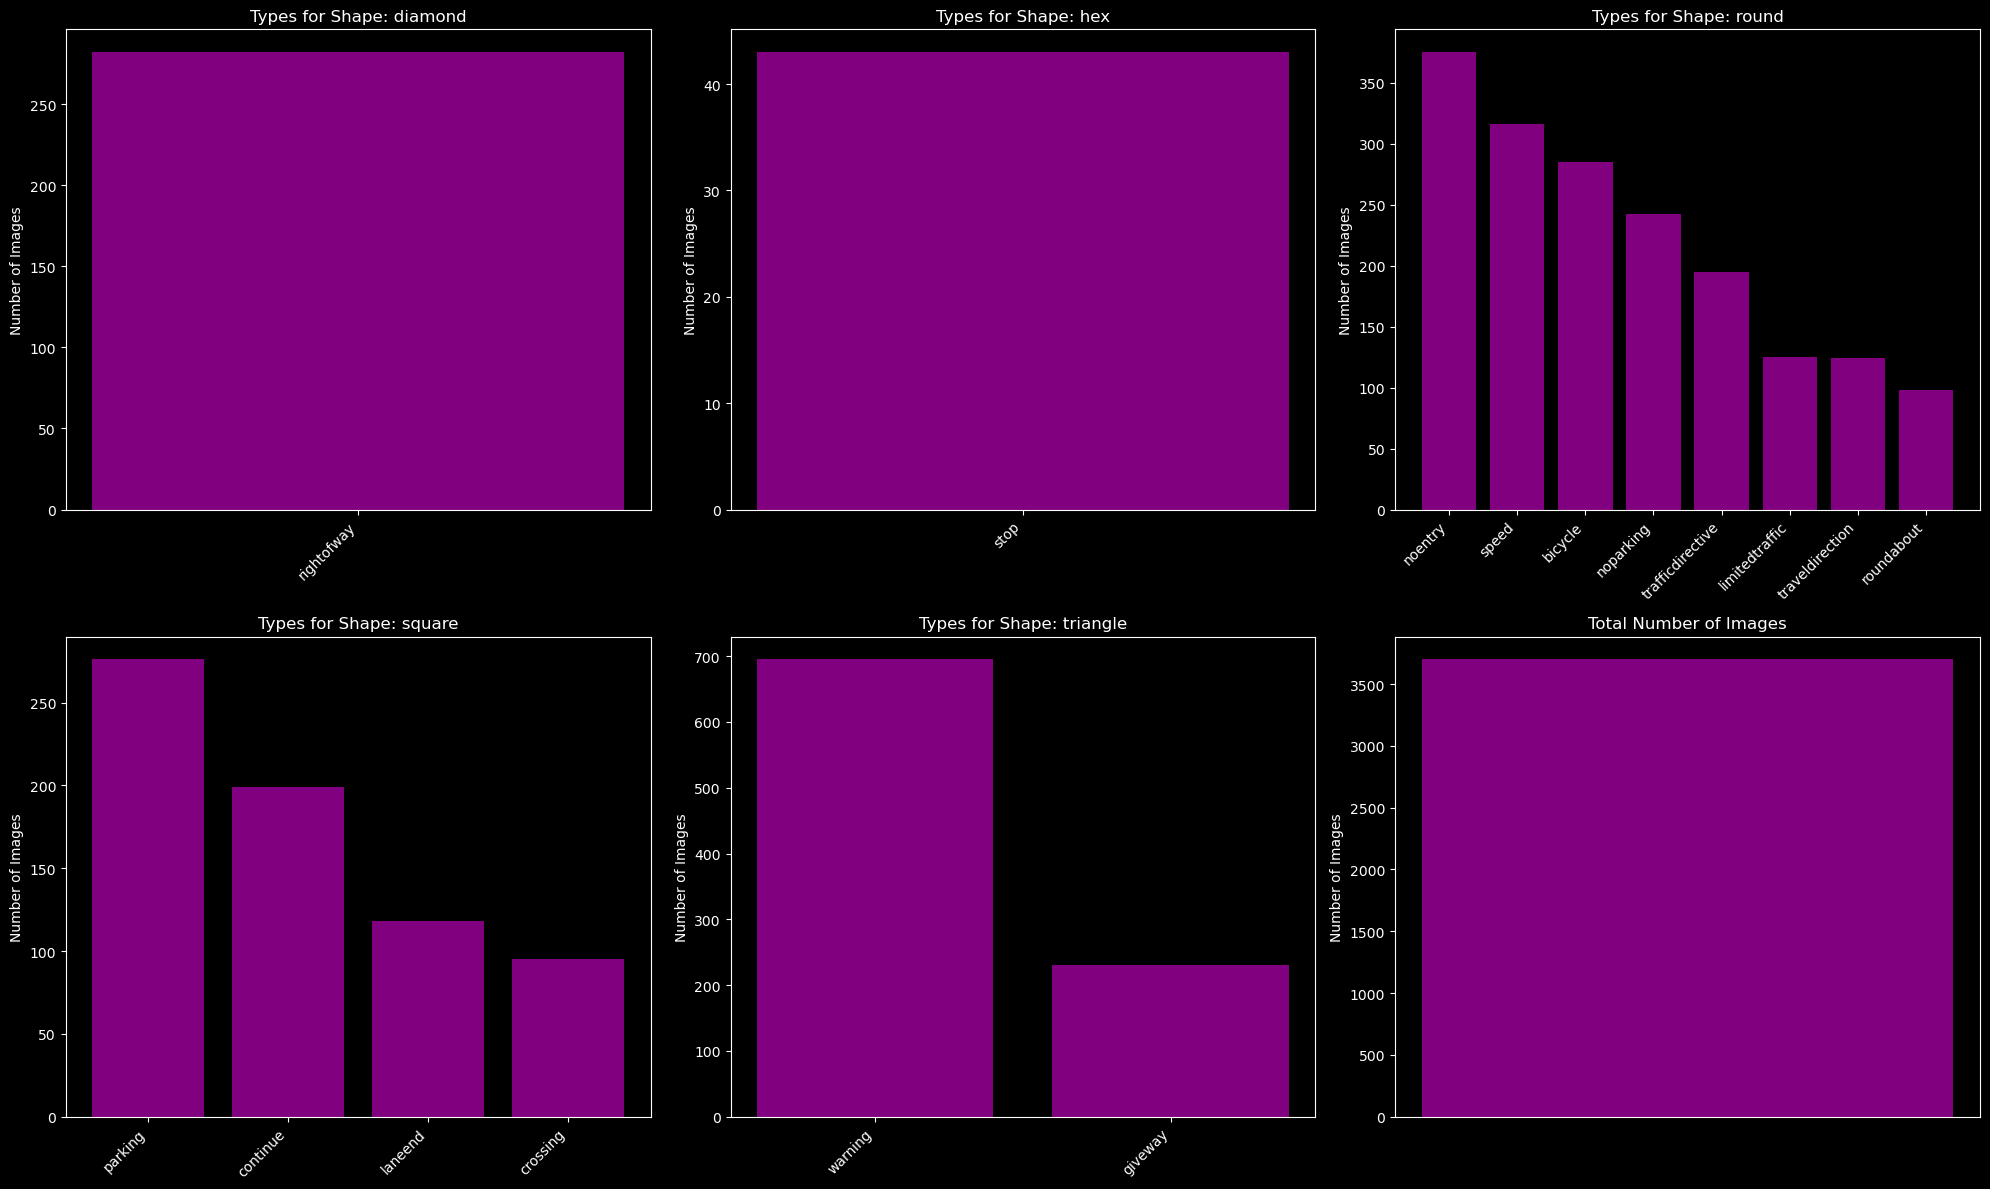

In [13]:
# Get the unique labels for each column
shape_labels = shape_encoder.classes_
type_labels = type_encoder.classes_

# Create a grid of subplots
plt.figure(figsize=(20, 12))

# Iterate over the shape labels
for i, shape in enumerate(shape_labels):
    plt.subplot(2, 3, i+1)
    
    # Filter the DataFrame for the current shape
    shape_df = df[df['shape_label'] == i]
    
    # Get the value counts for the type labels within the current shape
    type_counts = shape_df['type_label'].value_counts()
    
    # Get the actual type label names using the inverse transform of the type encoder
    type_names = type_encoder.inverse_transform(type_counts.index)
    
    # Plot the type counts as bars
    plt.bar(range(len(type_names)), type_counts, color='purple')
    plt.title(f"Types for Shape: {shape}")
    plt.xticks(range(len(type_names)), type_names, rotation=45, ha='right')
    plt.ylabel('Number of Images')
    
    # Print the class names and their counts to the console
    print(f"Shape: {shape}")
    for name, count in zip(type_names, type_counts):
        print(f"{name}: {count}")
    print()

# Create a separate plot for the total number of images
plt.subplot(2, 3, 6)
total_images = len(df)
plt.bar(0, total_images, color='purple')
plt.title("Total Number of Images")
plt.xticks([])
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

<h5 style="color:#D2B4DE; margin-top: 20px;">
<span style="font-size:1.5em;">📊</span> What observations can we make about the dataset?

<span style="font-size:1em;">✔</span> Observations:

<ul>
<li><b>Shape Distribution:</b> The dataset contains traffic signs of various shapes, including diamond, hex, round, square, and triangle. This diversity in shapes is important for training a robust classifier.</li><br>
<li><b>Type Distribution:</b> Within each shape category, there are multiple types of traffic signs. For example, within the round shape, we have signs related to speed, bicycle, noparking, trafficdirective, limitedtraffic, traveldirection, and roundabout. This suggests that the classifier needs to handle not only shape classification but also fine-grained type classification within each shape.</li><br>
<li><b>Imbalanced Classes:</b> The distribution of samples across different shapes and types is not uniform. Some classes, such as triangle warning (695 samples) and round noentry (375 samples), have significantly more samples compared to others like hex stop (43 samples). This class imbalance may require techniques like oversampling, undersampling, or class weights to prevent bias towards majority classes.</li><br>
<li><b>Hierarchical Structure:</b> The dataset exhibits a hierarchical structure, with shapes at the top level and types within each shape. This hierarchical relationship can be exploited by using hierarchical classification approaches or multi-task learning to improve the overall performance.</li><br>
<li><b>Semantic Meaning:</b> The traffic signs convey specific semantic meanings related to traffic rules and regulations. Understanding the semantic context of each sign type can help in interpreting the classifier's predictions and assessing its practical utility.</li><br>
<li><b>Potential Challenges:</b> The presence of visually similar sign types within the same shape category (e.g., speed and noparking within the round shape) may pose challenges for the classifier. Distinguishing between these similar types may require capturing subtle visual differences and leveraging contextual information.</li><br>
<li><b>Dataset Size:</b> The total number of samples in the dataset is not explicitly mentioned. However, considering the provided class-wise counts, the dataset seems to have a substantial number of samples, which is beneficial for training a deep learning model.</li><br>
</ul>
</h5>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">2.4 Data Splitting</h1>

<h5 style="color:#D2B4DE; margin-top: 20px;">
    <ul>
        <li>In this step, I will split <code>training.csv</code> into training and validation subsets to enable the training and testing of our model before we evaluate it against unseen 'blind' data that simulates a real input.</li>
        <br>
        <li>Following the recommendation by Azadeh and aligning with my personal preference for datasets of this size, I will implement an 80/20 split.</li>
        <br>
        <li>This approach is fundamental to our model development process, allowing us to assess the model's ability to generalize well beyond the training data.</li>
        <br>
        <li>A key aspect we emphasized in our lecture on supervised learning is the importance of having independent and identically distributed test data to avoid data leakage and ensure an unbiased evaluation of the final model.</li>
    </ul>
    <ul>
        <li>Given that we possess a distinct <code>test.csv</code>, which simulates real-world 'blind' data by excluding the target variable, our focus for the moment will shift towards dividing <code>training.csv</code> file into training and validation sets.</li>
        <br>
        <li>The division of <code>training.csv</code> is crucial for both the training and subsequent internal evaluation of our models, allowing us to refine them prior to the final assessment against the 'blind' test data.</li>
        <br>
        <li>To achieve a balanced distribution, I prefer an 80/20 split between the training and validation subsets, respectively, which suits datasets of this scale.</li>
        <br>
        <li>This structured approach underscores the model development phase, enabling us to meticulously gauge the model's generalization capabilities and ensure robustness before confronting the unseen data in <code>test.csv</code>.</li>
    </ul>
</h5>

In [11]:
# Custom preprocessing function
def preprocess_input(x):
    return x / 255.0

In [12]:
# Split the data into train and validation sets
train_indices, val_indices = train_test_split(df.index, test_size=0.2, random_state=42)

# Print the number of items in each dataset
print("Number of images in the training set:", len(train_indices))
print("Number of images in the validation set:", len(val_indices))

# Create data generators for training and validation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

Number of images in the training set: 2959
Number of images in the validation set: 740


<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">2.4-1 Checking for Data Leaks</h1>

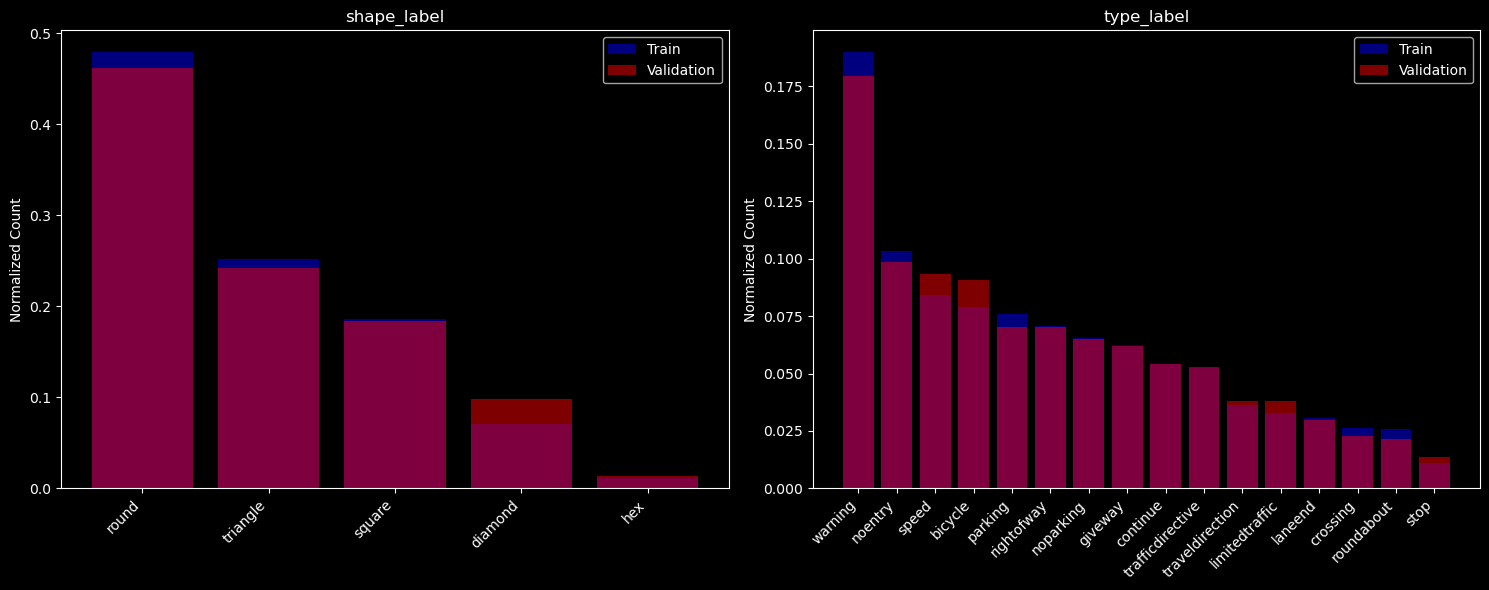

In [13]:
# Get the unique labels for each column
shape_labels = shape_encoder.classes_
type_labels = type_encoder.classes_

# Create a grid of subplots
plt.figure(figsize=(15, 6))

for i, col in enumerate(['shape_label', 'type_label']):
    plt.subplot(1, 2, i+1)

    # Get the value counts for the current column
    train_value_counts = df.loc[train_indices, col].value_counts(normalize=True)
    val_value_counts = df.loc[val_indices, col].value_counts(normalize=True)

    # Get the actual label names using the inverse transform of the encoders
    if col == 'shape_label':
        label_names = shape_encoder.inverse_transform(train_value_counts.index)
    else:
        label_names = type_encoder.inverse_transform(train_value_counts.index)

    # Plot the normalized value counts as bars
    bar_width = 0.8
    x_positions = np.arange(len(label_names))
    plt.bar(x_positions, train_value_counts, bar_width, color='blue', label='Train', alpha=0.5)
    plt.bar(x_positions, val_value_counts, bar_width, color='red', label='Validation', alpha=0.5)
    plt.title(col)
    plt.xticks(x_positions, label_names, rotation=45, ha='right')
    plt.ylabel('Normalized Count')
    plt.legend()
    plt.tight_layout()

plt.show()

<h5 style="color:#D2B4DE; margin-top: 20px;">
    <ul>
        <li>Random splitting is essential but may lead to leakage if two splits are not truly independent.<br><br></li>
        <li>We will utilize insights from Exploratory Data Analysis (EDA) to detect any hidden sources of leakage in the dataset.<br><br></li>
        <li>We will examine histograms for each attribute in the training and validation sets, using different colors, to ensure the splits are identically distributed.</li>
    </ul>
</h5>

In [14]:
# Load and preprocess the image data
def load_and_preprocess_image(image_path):
    img = imageio.imread(image_path)
    img = img / 255.0
    return img.flatten()

# Prepare the input data and labels
X_train = np.array([load_and_preprocess_image(image_path) for image_path in df.iloc[train_indices]['image_path']])
X_val = np.array([load_and_preprocess_image(image_path) for image_path in df.iloc[val_indices]['image_path']])

y_train_shape = df.iloc[train_indices]['shape_label'].values
y_train_type = df.iloc[train_indices]['type_label'].values

y_val_shape = df.iloc[val_indices]['shape_label'].values
y_val_type = df.iloc[val_indices]['type_label'].values

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">2.5-1 (⚠) Oversampling</h1>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">WARNING: ⚠ Don't run this for optimal results.</h1>

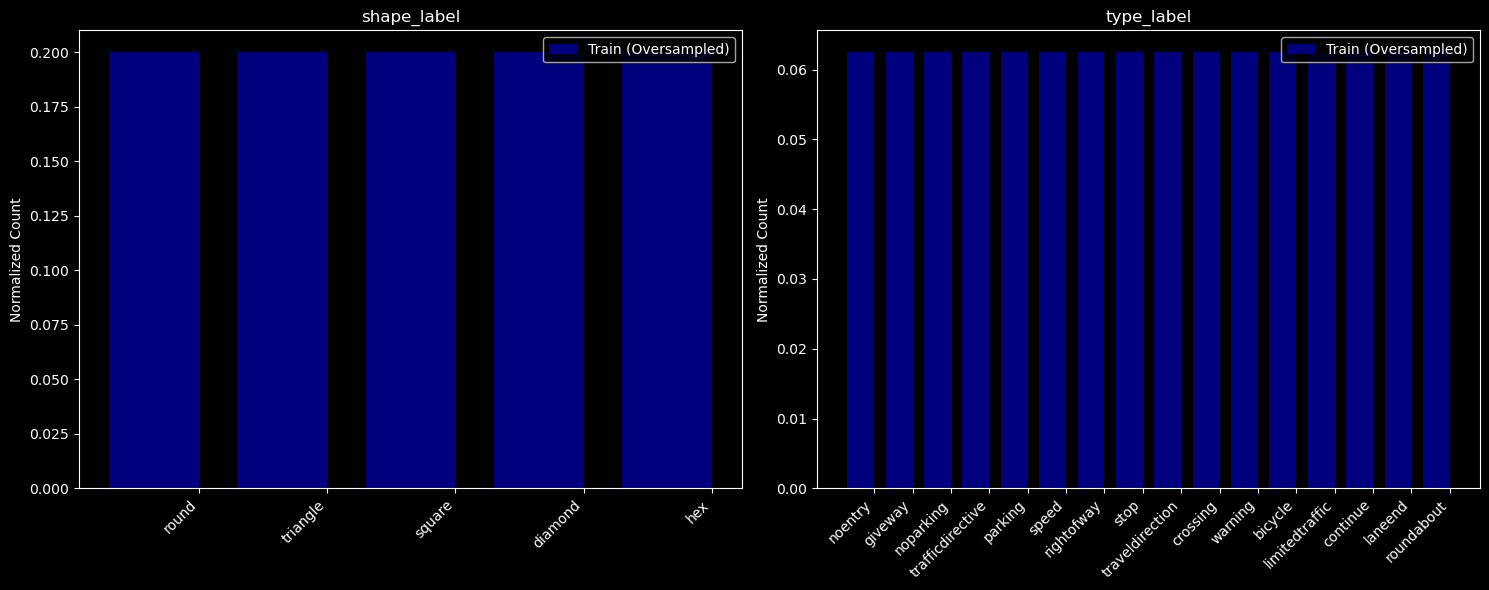

In [9]:
# Get the unique labels for each column
shape_labels = shape_encoder.classes_
type_labels = type_encoder.classes_

# Create a grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

for i, (col, ax) in enumerate(zip(['shape_label', 'type_label'], axs)):
    
    # Oversample the minority classes in the training set
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(df.loc[train_indices, df.columns != col],
                                                            df.loc[train_indices, col])
    train_value_counts_resampled = pd.Series(y_train_resampled).value_counts(normalize=True)

    # Oversample the minority classes in the validation set
    X_val_resampled, y_val_resampled = ros.fit_resample(df.loc[val_indices, df.columns != col],
                                                        df.loc[val_indices, col])
    val_value_counts_resampled = pd.Series(y_val_resampled).value_counts(normalize=True)

    # Get the actual label names using the inverse transform of the encoders
    label_names = shape_encoder.inverse_transform(train_value_counts_resampled.index) if col == 'shape_label' else type_encoder.inverse_transform(train_value_counts_resampled.index)

    # Plot the normalized value counts after oversampling
    bar_width = 0.7
    x_positions = np.arange(len(label_names))
    ax.bar(x_positions - bar_width / 2, train_value_counts_resampled, bar_width, color='blue', label='Train (Oversampled)', alpha=0.5)
    ax.set_title(col)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(label_names, rotation=45, ha='right')
    ax.set_ylabel('Normalized Count')
    ax.legend()

fig.tight_layout()
plt.show()

In [10]:
# Load and preprocess the image data
def load_and_preprocess_image(image_path):
    img = imageio.imread(image_path)
    img = img / 255.0
    return img.flatten()

# Get the flattened image data and target labels for the training set
X_train_images = np.array([load_and_preprocess_image(image_path) for image_path in df.iloc[train_indices]['image_path']])
y_train_shape = df.iloc[train_indices]['shape_label'].values
y_train_type = df.iloc[train_indices]['type_label'].values

# Get the flattened image data and target labels for the validation set
X_val_images = np.array([load_and_preprocess_image(image_path) for image_path in df.iloc[val_indices]['image_path']])
y_val_shape = df.iloc[val_indices]['shape_label'].values
y_val_type = df.iloc[val_indices]['type_label'].values

# Oversample the minority classes only in the training set
ros = RandomOverSampler(random_state=42)
X_train_shape, y_train_shape = ros.fit_resample(X_train_images, y_train_shape)
X_train_type, y_train_type = ros.fit_resample(X_train_images, y_train_type)

# Truncate the larger array to match the size of the smaller array
min_samples = min(len(X_train_shape), len(X_train_type))
X_train = X_train_shape[:min_samples]
y_train_shape = y_train_shape[:min_samples]
y_train_type = y_train_type[:min_samples]

# Overwrite the validation variables with the non-oversampled data
X_val = X_val_images
y_val_shape = y_val_shape
y_val_type = y_val_type

<li><b>Oversampling Considerations:</b>
<ul>
<br><li>Oversampling can create a more generalizable dataset by increasing the representation of minority classes, which is useful for imbalanced datasets. We observed that our independently collected dataset closely correlates with the combined training and validation dataset when normalized.</li>
<br><li>If this model were deployed in a real-world setting, it would likely benefit from oversampling to help generalize better to unseen data. However, our numerous tests have shown that applying oversampling leads to a decrease in model performance, possibly due to the introduction of noise or unrealistic synthetic examples.</li>
<br><li>While oversampling is valuable for improving model generalization, it is crucial to evaluate its impact on the specific dataset and problem. In our case, we have determined that oversampling does not provide the desired performance improvements, and we will proceed without applying this technique.</li>
</ul>
</li>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">3.0 Non-Neural Network Algorithms</h1>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">SKIP TO X FOR THE BASELINE MODEL, JUST KNOW WE TRAINED, AND TRIED OTHER MODELS BEFORE SETTLING FOR OUR BASELINE :)</h1>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h2 style="color:#7D3C98; font-size: 18px;">If you are interested please unhide the following cells to see training, and validation of our pre-baseline models.</h1>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">3.1 Logistic Regression Classifier</h1>

<li><b>Logistic Regression as a Starting Point:</b>
<ul>
<br><li>Using logistic regression with the sigmoid activation function as a first step before moving on to more complex models like neural networks and tree-based algorithms is beneficial for several reasons:
<ul>
<li>Logistic regression provides a simple and interpretable baseline model, allowing us to quickly assess the feasibility of the classification task and establish a performance benchmark.</li>
<li>It helps us understand the relationship between the input features and the target variable, giving insights into the importance of different features.</li>
<li>Logistic regression is computationally efficient and can handle high-dimensional data, making it a good choice for initial experiments and iterations.</li>
</ul>
</li>
<br><li>By starting with logistic regression, we can gain valuable insights into the problem and make informed decisions about the need for more advanced techniques like neural networks or tree-based algorithms, which can capture more complex patterns and relationships in the data.</li>
</ul>
</li>

Shape Accuracy: 0.9486486486486486
Type Accuracy: 0.9581081081081081

Shape Classification Report:
              precision    recall  f1-score   support

     diamond       0.97      0.92      0.94        73
         hex       1.00      0.80      0.89        10
       round       0.94      0.98      0.96       342
      square       0.94      0.92      0.93       136
    triangle       0.96      0.93      0.95       179

    accuracy                           0.95       740
   macro avg       0.96      0.91      0.93       740
weighted avg       0.95      0.95      0.95       740


Type Classification Report:
                  precision    recall  f1-score   support

         bicycle       0.96      0.98      0.97        52
        continue       0.97      0.97      0.97        39
        crossing       1.00      0.88      0.94        17
         giveway       0.98      0.98      0.98        46
         laneend       1.00      0.93      0.96        28
  limitedtraffic       0.86      0

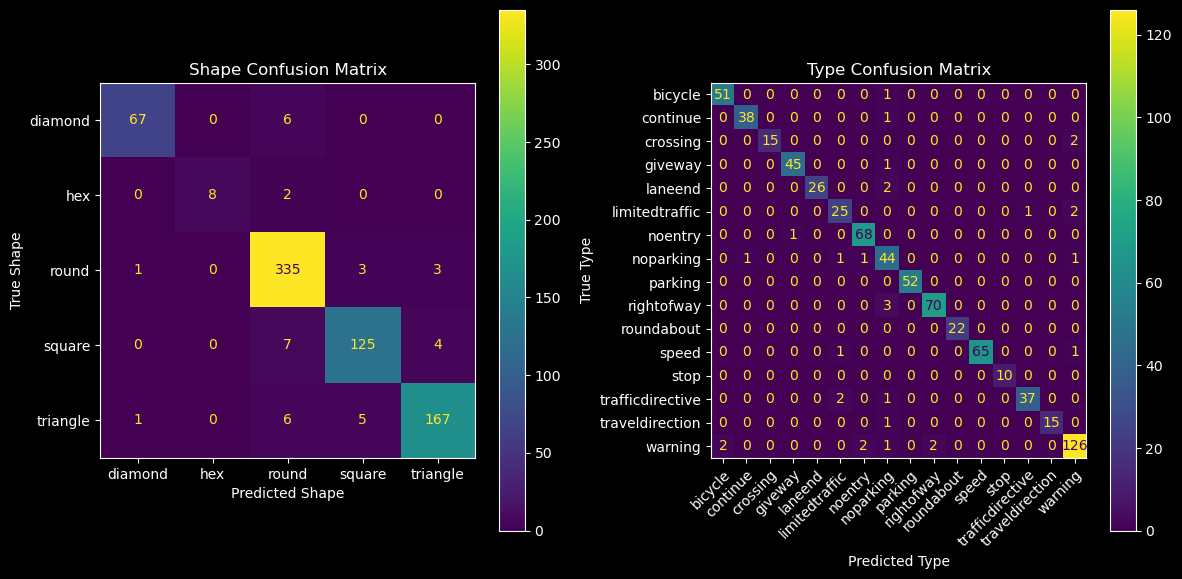

In [18]:
# Create logistic regression models for shape and type
shape_classifier = LogisticRegression()
type_classifier = LogisticRegression()

# Train the models
shape_classifier.fit(X_train, y_train_shape)
type_classifier.fit(X_train, y_train_type)

# Make predictions on the validation set
shape_pred = shape_classifier.predict(X_val)
type_pred = type_classifier.predict(X_val)

# Evaluate the models
shape_acc = shape_classifier.score(X_val, y_val_shape)
type_acc = type_classifier.score(X_val, y_val_type)

print("Shape Accuracy:", shape_acc)
print("Type Accuracy:", type_acc)

# Print classification reports
print("\nShape Classification Report:")
print(classification_report(y_val_shape, shape_pred, target_names=shape_encoder.classes_))

print("\nType Classification Report:")
print(classification_report(y_val_type, type_pred, target_names=type_encoder.classes_))

# Create confusion matrices
shape_cm = confusion_matrix(y_val_shape, shape_pred)
type_cm = confusion_matrix(y_val_type, type_pred)

# Plot the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot(ax=ax1)
ax1.set_title("Shape Confusion Matrix")
ax1.set_xlabel("Predicted Shape")
ax1.set_ylabel("True Shape")

ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot(ax=ax2)
ax2.set_title("Type Confusion Matrix")
ax2.set_xlabel("Predicted Type")
ax2.set_ylabel("True Type")

# Rotate the x-axis labels of the Type Confusion Matrix
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">3.2 Decision Tree Classifier</h1>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.2-1 Decision Tree Hyperparameter Tuning</h1>

In [19]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create Decision Tree classifiers for shape and type
shape_dt = DecisionTreeClassifier(random_state=42)
type_dt = DecisionTreeClassifier(random_state=42)

# Perform GridSearchCV for shape classifier
shape_grid_search = GridSearchCV(shape_dt, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
shape_grid_search.fit(X_train, y_train_shape)

# Perform GridSearchCV for type classifier
type_grid_search = GridSearchCV(type_dt, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
type_grid_search.fit(X_train, y_train_type)

# Print the best parameters for shape classifier
print("Best Parameters for Shape Classifier:")
print(shape_grid_search.best_params_)

# Print the best parameters for type classifier
print("Best Parameters for Type Classifier:")
print(type_grid_search.best_params_)

Best Parameters for Shape Classifier:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Parameters for Type Classifier:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.2-2 Decision Tree Training</h1>

In [20]:
# Create the hypertuned Decision Tree classifiers with the best parameters
shape_dt_best = DecisionTreeClassifier(**shape_grid_search.best_params_, random_state=42)
type_dt_best = DecisionTreeClassifier(**type_grid_search.best_params_, random_state=42)

# Train the hypertuned Decision Tree classifiers
shape_dt_best.fit(X_train, y_train_shape)
type_dt_best.fit(X_train, y_train_type)

DecisionTreeClassifier(criterion='entropy', min_samples_split=5,
                       random_state=42)

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.2-3 Decision Tree Validation</h1>

Shape Accuracy: 0.8635135135135135
Type Accuracy: 0.8364864864864865


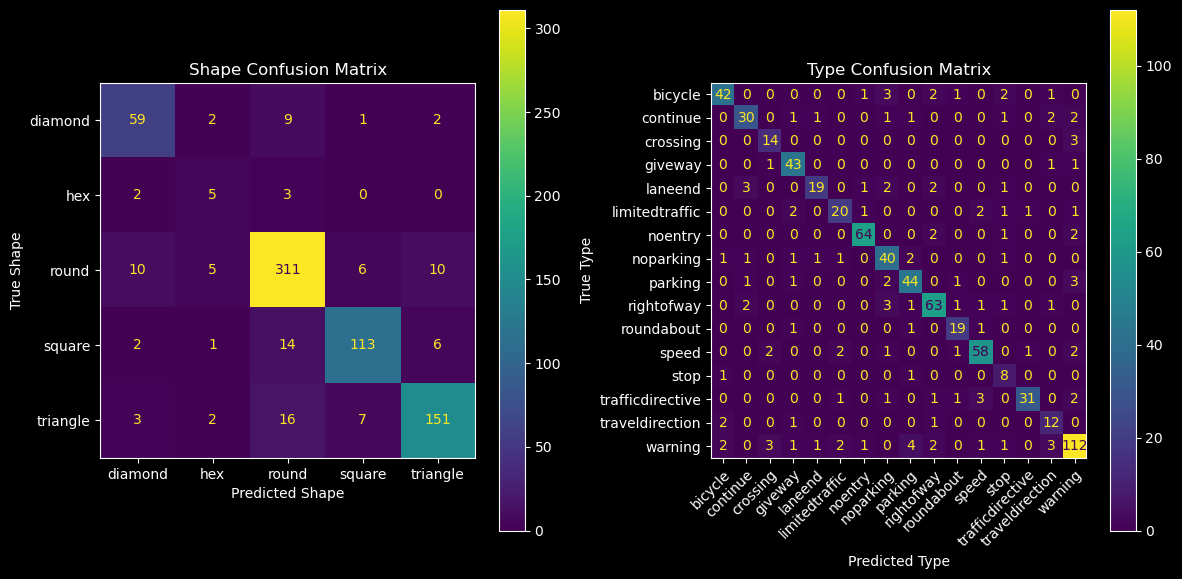

In [21]:
# Make predictions on the validation set
shape_pred = shape_dt_best.predict(X_val)
type_pred = type_dt_best.predict(X_val)

# Evaluate the hypertuned Decision Tree classifiers on the validation set
shape_acc = shape_dt_best.score(X_val, y_val_shape)
type_acc = type_dt_best.score(X_val, y_val_type)

print("Shape Accuracy:", shape_acc)
print("Type Accuracy:", type_acc)

# Create confusion matrices
shape_cm = confusion_matrix(y_val_shape, shape_pred)
type_cm = confusion_matrix(y_val_type, type_pred)

# Plot the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot(ax=ax1)
ax1.set_title("Shape Confusion Matrix")
ax1.set_xlabel("Predicted Shape")
ax1.set_ylabel("True Shape")

ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot(ax=ax2)
ax2.set_title("Type Confusion Matrix")
ax2.set_xlabel("Predicted Type")
ax2.set_ylabel("True Type")

# Rotate the x-axis labels of the Type Confusion Matrix
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">3.3 Random Forest</h1>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.3-1 Decision Tree Hyperparameter Tuning</h1>

In [22]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create Random Forest classifiers for shape and type
shape_rf = RandomForestClassifier(random_state=42)
type_rf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV for shape classifier
shape_grid_search = GridSearchCV(shape_rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
shape_grid_search.fit(X_train, y_train_shape)

# Perform GridSearchCV for type classifier
type_grid_search = GridSearchCV(type_rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
type_grid_search.fit(X_train, y_train_type)

# Print the best parameters for shape classifier
print("Best Parameters for Shape Classifier:")
print(shape_grid_search.best_params_)

# Print the best parameters for type classifier
print("Best Parameters for Type Classifier:")
print(type_grid_search.best_params_)

Best Parameters for Shape Classifier:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Parameters for Type Classifier:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.3-2 Random Forest Training</h1>

In [23]:
# Create the hypertuned Random Forest classifiers with the best parameters
shape_rf_best = RandomForestClassifier(**shape_grid_search.best_params_, random_state=42)
type_rf_best = RandomForestClassifier(**type_grid_search.best_params_, random_state=42)

# Train the hypertuned Random Forest classifiers
shape_rf_best.fit(X_train, y_train_shape)
type_rf_best.fit(X_train, y_train_type)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.3-3 Random Forest Validation</h1>

Shape Accuracy: 0.9540540540540541
Type Accuracy: 0.9594594594594594


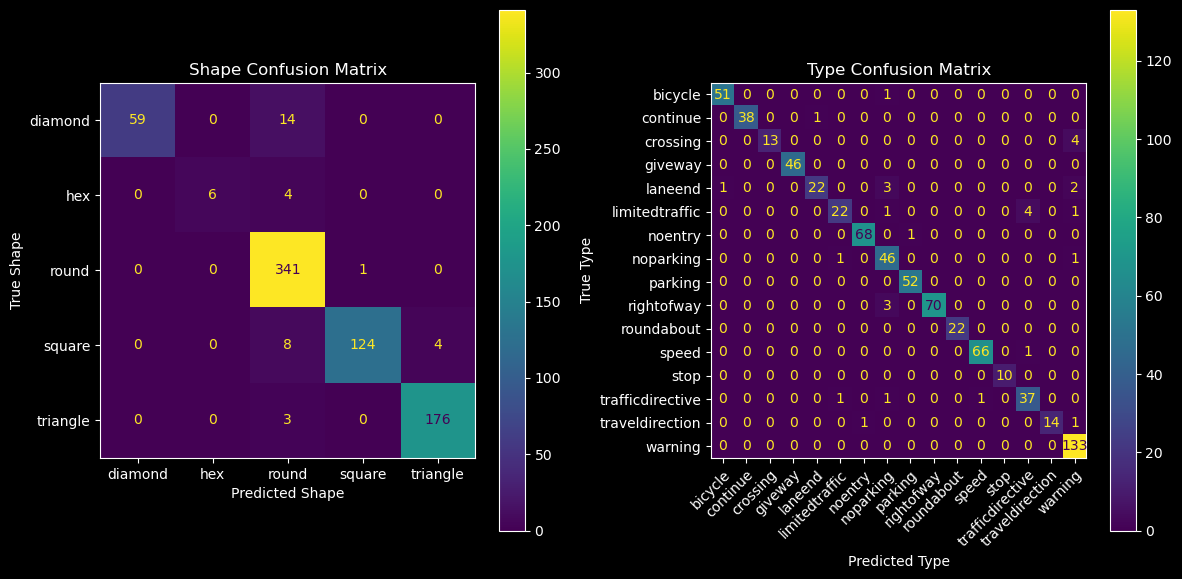

In [24]:
# Make predictions on the validation set
shape_pred = shape_rf_best.predict(X_val)
type_pred = type_rf_best.predict(X_val)

# Evaluate the hypertuned Random Forest classifiers on the validation set
shape_acc = shape_rf_best.score(X_val, y_val_shape)
type_acc = type_rf_best.score(X_val, y_val_type)

print("Shape Accuracy:", shape_acc)
print("Type Accuracy:", type_acc)

# Create confusion matrices
shape_cm = confusion_matrix(y_val_shape, shape_pred)
type_cm = confusion_matrix(y_val_type, type_pred)

# Plot the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot(ax=ax1)
ax1.set_title("Shape Confusion Matrix")
ax1.set_xlabel("Predicted Shape")
ax1.set_ylabel("True Shape")

ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot(ax=ax2)
ax2.set_title("Type Confusion Matrix")
ax2.set_xlabel("Predicted Type")
ax2.set_ylabel("True Type")

# Rotate the x-axis labels of the Type Confusion Matrix
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

<li><b>Validation Performance of Tree-Based Algorithms:</b>
<ul>
<br><li>We primarily used Accuracy as a baseline metric to quickly gauge the overall effectiveness of the tree-based models, namely Decision Tree (DT) and Random Forest (RF).</li>
<br><li>Decision Tree (DT) Performance:
<ul>
<li>Shape Accuracy: 0.8635135135135135</li>
<li>Type Accuracy: 0.8364864864865</li>
</ul>
</li>
<br><li>Random Forest (RF) Performance:
<ul>
<li>Shape Accuracy: 0.9540540540541</li>
<li>Type Accuracy: 0.9594594594594</li>
</ul>
</li>
<br><li>To optimize the performance of these models, we employed a GridSearch to find the best hyperparameters. The hyperparameters tuned for each model were:
<ul>
<li>Decision Tree: criterion, max_depth, min_samples_leaf, min_samples_split</li>
<li>Random Forest: max_depth, min_samples_leaf, min_samples_split, n_estimators</li>
</ul>
</li>
<br><li>The Random Forest model outperformed the Decision Tree model in both Shape and Type classification tasks, achieving accuracies of around 95%. This improvement can be attributed to the ensemble nature of Random Forest, which combines multiple decision trees to make more robust predictions.</li>
</ul>
</li>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">3.4 Gradient Boosted Ensemble Classifier</h1>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.4-1 Gradient Boosted Ensemble Classifier Hyperparameter Tuning</h1>

In [25]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

# Create Gradient Boosting classifiers for shape and type
shape_gb = GradientBoostingClassifier(random_state=42)
type_gb = GradientBoostingClassifier(random_state=42)

# Perform GridSearchCV for shape classifier
shape_grid_search = GridSearchCV(shape_gb, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
shape_grid_search.fit(X_train, y_train_shape)

# Perform GridSearchCV for type classifier
type_grid_search = GridSearchCV(type_gb, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
type_grid_search.fit(X_train, y_train_type)

# Print the best parameters for shape classifier
print("Best Parameters for Shape Classifier:")
print(shape_grid_search.best_params_)

# Print the best parameters for type classifier
print("Best Parameters for Type Classifier:")
print(type_grid_search.best_params_)

Best Parameters for Shape Classifier:
{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 0.8}
Best Parameters for Type Classifier:
{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 1.0}


<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.4-2 Gradient Boosted Ensemble Classifier Training</h1>

In [26]:
# Create the hypertuned Gradient Boosting classifiers with the best parameters
shape_gb_best = GradientBoostingClassifier(**shape_grid_search.best_params_, random_state=42)
type_gb_best = GradientBoostingClassifier(**type_grid_search.best_params_, random_state=42)

# Train the hypertuned Gradient Boosting classifiers
shape_gb_best.fit(X_train, y_train_shape)
type_gb_best.fit(X_train, y_train_type)

GradientBoostingClassifier(max_depth=5, max_features='sqrt', random_state=42)

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.4-3 Gradient Boosted Ensemble Classifier Validation</h1>

Shape Accuracy: 0.9608108108108108
Type Accuracy: 0.95


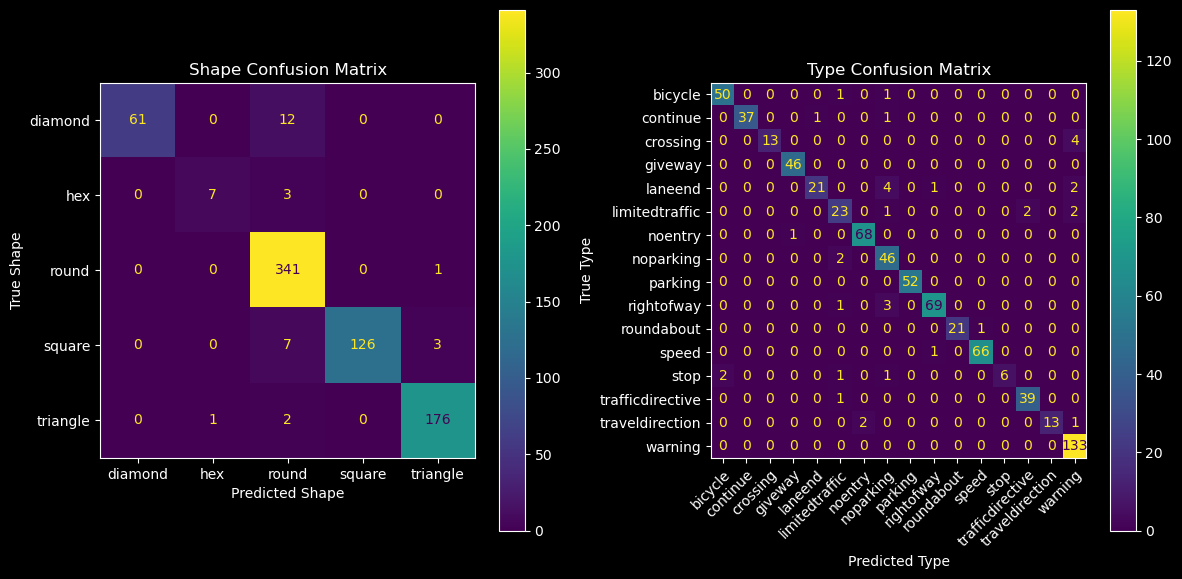

In [27]:
# Make predictions on the validation set
shape_pred = shape_gb_best.predict(X_val)
type_pred = type_gb_best.predict(X_val)

# Evaluate the hypertuned Gradient Boosting classifiers on the validation set
shape_acc = shape_gb_best.score(X_val, y_val_shape)
type_acc = type_gb_best.score(X_val, y_val_type)

print("Shape Accuracy:", shape_acc)
print("Type Accuracy:", type_acc)

# Create confusion matrices
shape_cm = confusion_matrix(y_val_shape, shape_pred)
type_cm = confusion_matrix(y_val_type, type_pred)

# Plot the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot(ax=ax1)
ax1.set_title("Shape Confusion Matrix")
ax1.set_xlabel("Predicted Shape")
ax1.set_ylabel("True Shape")

ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot(ax=ax2)
ax2.set_title("Type Confusion Matrix")
ax2.set_xlabel("Predicted Type")
ax2.set_ylabel("True Type")

# Rotate the x-axis labels of the Type Confusion Matrix
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

<li><b>Validation Performance of XGBoost Algorithm:</b>
<ul>
<br><li>We applied the XGBoost algorithm to our classification task and used Accuracy as the primary metric to evaluate its performance.</li>
<br><li>XGBoost Performance:
<ul>
<li>Shape Accuracy: 0.9486486486486486</li>
<li>Type Accuracy: 0.9445945945945946</li>
</ul>
</li>
<br><li>We employed a GridSearch to find the best hyperparameters for the XGBoost model. The hyperparameters tuned were: subsample, n_estimators, max_features, max_depth, and learning_rate.</li>
<br><li>Benefits of XGBoost over traditional tree-based algorithms:
<ul>
<li>XGBoost incorporates regularization techniques to control model complexity and prevent overfitting.</li>
<li>It utilizes a gradient boosting framework, which iteratively improves the model's performance by focusing on misclassified instances.</li>
</ul>
</li>
<br><li>Drawback of XGBoost:
<ul>
<li>XGBoost has a higher computational cost compared to simpler tree-based algorithms like Decision Trees, as it requires training multiple models in an iterative manner.</li>
</ul>
</li>
</ul>
</li>

<li><b>Non-Neural Network Algorithm Conclusion:</b>
<ul>
<br><li>Non-neural network algorithms, such as Decision Trees, Random Forests, and XGBoost, have shown surprisingly good performance in our n-ary image classification task. These algorithms have achieved accuracies ranging from 86% to 95%, demonstrating their effectiveness in capturing relevant patterns and making accurate predictions.</li>
<br><li>While neural networks, particularly Convolutional Neural Networks (CNNs), are often the go-to choice for image classification tasks due to their ability to learn hierarchical representations, our results highlight that traditional machine learning algorithms can still provide competitive performance, especially when dealing with relatively small datasets or when computational resources are limited.</li>
<br><li>GridSearchCV, a wrapper-based hyperparameter tuning technique, has been employed to fine-tune the hyperparameters of our non-neural network algorithms. By exhaustively searching through a predefined parameter grid, GridSearchCV helps us find the optimal combination of hyperparameters that maximizes the performance of our models. This systematic approach to hyperparameter tuning has contributed to the high accuracies achieved by our non-neural network algorithms.</li>
<br><li>Ensemble methods, such as Random Forests and XGBoost, leverage the power of multiple weak learners to create a strong and robust classifier. These algorithms employ techniques like bagging and boosting to improve performance:
<ul>
<li>Bagging (Bootstrap Aggregating) involves training multiple classifiers independently on random subsets of the training data and combining their predictions through majority voting or averaging. This helps reduce overfitting and improves generalization.</li>
<li>Boosting, used in algorithms like XGBoost, iteratively trains weak classifiers, giving more importance to misclassified samples in each iteration. The final prediction is obtained by weighted voting of the weak classifiers. Boosting focuses on difficult examples and can effectively capture complex patterns in the data.</li>
</ul>
</li>
</ul>
</li>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">4.0 Neural Networks</h1>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">4.1 Multi-Layer-Perceptron Classifier (Baseline Model)</h1>

In [115]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df.iloc[train_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=img_size,
    batch_size=32,
    class_mode='multi_output'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df.iloc[val_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=img_size,
    batch_size=32,
    class_mode='multi_output'
)

Found 2959 validated image filenames.
Found 740 validated image filenames.


<li><b>Multilayer Perceptron (MLP) for Image Classification:</b>
<ul>
<br><li>A Multilayer Perceptron (MLP) is a type of artificial neural network that consists of multiple layers of interconnected nodes (neurons). It typically comprises an input layer, one or more hidden layers, and an output layer.</li>
<br><li>MLPs are useful for image classification tasks because:
<ul>
<li>They can learn complex, non-linear relationships between the input features (pixel values) and the output classes.</li>
<li>The multiple layers allow the network to learn hierarchical representations of the image data, capturing increasingly abstract features as the information propagates through the layers.</li>
<li>MLPs can handle high-dimensional input data, such as flattened image pixels, making them suitable for processing and classifying images.</li>
</ul>
</li>
<br><li>In an MLP, the input layer receives the flattened image pixels, and the information is then passed through the hidden layers, where each neuron applies a non-linear activation function to its weighted inputs. The output layer produces the final class probabilities or predictions.</li>
<br><li>During training, the MLP learns the optimal weights and biases for each neuron using backpropagation and gradient descent optimization. This allows the network to minimize the classification error and improve its performance iteratively.</li>
</ul>
</li>

In [102]:
# Define the input shape and number of classes
input_shape = (28, 28, 3)
num_shape_classes = len(shape_encoder.classes_)
num_type_classes = len(type_encoder.classes_)

# Load image data and labels
X_train = np.array([img_to_array(load_img(path, target_size=input_shape)) / 255.0 for path in df.iloc[train_indices]['image_path']])
y_train_shape = np.array(df.iloc[train_indices]['shape_label'])
y_train_type = np.array(df.iloc[train_indices]['type_label'])

X_val = np.array([img_to_array(load_img(path, target_size=input_shape)) / 255.0 for path in df.iloc[val_indices]['image_path']])
y_val_shape = np.array(df.iloc[val_indices]['shape_label'])
y_val_type = np.array(df.iloc[val_indices]['type_label'])

# Create the model architecture
inputs = keras.Input(shape=input_shape)
x = Flatten()(inputs)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)

# Output layers for shape and type
shape_output = Dense(num_shape_classes, activation='softmax', name='shape')(x)
type_output = Dense(num_type_classes, activation='softmax', name='type')(x)

# Create the model
model = Model(inputs=inputs, outputs=[shape_output, type_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'shape': 'sparse_categorical_crossentropy',
                    'type': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, {'shape': y_train_shape, 'type': y_train_type},
                    validation_data=(X_val, {'shape': y_val_shape, 'type': y_val_type}),
                    epochs=10, batch_size=32)

Epoch 1/10
93/93 [==============================] - 6s 63ms/step - loss: 3.6656 - shape_loss: 1.1669 - type_loss: 2.4987 - shape_accuracy: 0.5336 - type_accuracy: 0.2214 - val_loss: 2.8790 - val_shape_loss: 0.8824 - val_type_loss: 1.9966 - val_shape_accuracy: 0.6486 - val_type_accuracy: 0.3649
Epoch 2/10
93/93 [==============================] - 7s 74ms/step - loss: 2.6038 - shape_loss: 0.7514 - type_loss: 1.8524 - shape_accuracy: 0.7056 - type_accuracy: 0.4137 - val_loss: 1.9874 - val_shape_loss: 0.5690 - val_type_loss: 1.4183 - val_shape_accuracy: 0.7716 - val_type_accuracy: 0.6054
Epoch 3/10
93/93 [==============================] - 7s 78ms/step - loss: 2.1174 - shape_loss: 0.6160 - type_loss: 1.5014 - shape_accuracy: 0.7577 - type_accuracy: 0.5117 - val_loss: 1.4808 - val_shape_loss: 0.4208 - val_type_loss: 1.0600 - val_shape_accuracy: 0.8392 - val_type_accuracy: 0.6743
Epoch 4/10
93/93 [==============================] - 8s 91ms/step - loss: 1.7225 - shape_loss: 0.4774 - type_loss: 1

<h5 style="color:#D2B4DE; margin-top: 20px;">
<span style="font-size:1.5em;">🔍</span> Justification for each MLP layer:

<span style="font-size:1em;">✔</span> Flatten Layer:

<ul>
<li>We used a Flatten layer to convert the 2D input image (28x28) into a 1D vector because it is necessary to prepare the data for the subsequent fully connected layers. Flattening the input allows the model to treat the image as a simple vector, enabling it to learn global patterns and relationships between pixels more efficiently.</li>
</ul>

<span style="font-size:1em;">✔</span> Dense Layer (128 units, ReLU):

<ul>
<li>We chose a Dense layer with 128 units as the first hidden layer because it provides a sufficient capacity for the model to capture intricate features and patterns in the input data. The ReLU activation function is used to introduce non-linearity, allowing the model to learn complex patterns and representations more effectively. ReLU activation also helps in faster convergence and reduces the likelihood of vanishing gradients.</li>
</ul>

<span style="font-size:1em;">✔</span> Dropout Layer (0.3):

<ul>
<li>We included a Dropout layer with a rate of 0.3 to regularize the model and prevent overfitting. Dropout encourages the model to learn more robust and generalized features by randomly setting a fraction of the input units to 0 during training. This reduces the reliance on specific neurons and enhances the model's ability to generalize to unseen data, leading to better performance on the validation set.</li>
</ul>

<span style="font-size:1em;">✔</span> Dense Layer (64 units, ReLU):

<ul>
<li>We used a Dense layer with 64 units as the second hidden layer to gradually compress the learned representations and extract higher-level features. The reduced number of units helps in capturing more abstract and discriminative patterns relevant to the classification task. ReLU activation is used again for non-linearity, enabling the model to learn complex relationships between the features.</li>
</ul>

<span style="font-size:1em;">✔</span> Dense Layer (32 units, ReLU):

<ul>
<li>We included a final Dense layer with 32 units to learn the most discriminative and compact representations required for the classification task. The further reduction in the number of units allows the model to focus on the essential features while reducing the risk of overfitting. ReLU activation helps in capturing non-linear relationships and maintaining the model's expressive power.</li>
</ul>

<span style="font-size:1em;">✔</span> Output Layers (Shape and Type):

<ul>
<li>We used two separate output layers, one for shape classification (5 units) and another for type classification (17 units), because the task involves predicting both the shape and type of road signs. The softmax activation function is applied in each output layer to produce probability distributions over the respective classes. Softmax ensures that the outputs sum up to 1 and can be interpreted as class probabilities, providing a clear and interpretable output for the classification task.</li>
</ul>
</h5>

In [ ]:
incremental changes

In [ ]:
however we're doing images which contain spatial data which would benefit from filters

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">4.2 Convolutional Neural Network</h1>

<h5 style="color:#D2B4DE; margin-top: 20px;">
<span style="font-size:1.5em;">🔍</span> How CNN differs from MLPs:

<span style="font-size:1em;">✔</span> Local Connectivity:

<ul>
<li>Unlike MLPs, which are fully connected, CNNs exploit local connectivity by applying convolutional filters to small regions of the input. This allows CNNs to capture spatially local patterns and learn translation-invariant features, making them well-suited for image and pattern recognition tasks.</li>
</ul>

<span style="font-size:1em;">✔</span> Parameter Sharing:

<ul>
<li>In CNNs, the weights of the convolutional filters are shared across different positions of the input. This parameter sharing reduces the number of learnable parameters compared to MLPs, making CNNs more computationally efficient and less prone to overfitting.</li>
</ul>

<span style="font-size:1em;">✔</span> Hierarchical Feature Learning:

<ul>
<li>CNNs learn hierarchical representations of the input data through successive convolutional and pooling layers. Lower layers capture low-level features like edges and textures, while higher layers learn more abstract and complex features. This hierarchical learning enables CNNs to automatically extract relevant features from raw input data.</li>
</ul>

<span style="font-size:1em;">✔</span> Spatial Invariance:

<ul>
<li>CNNs achieve spatial invariance through pooling operations, which downsample the feature maps and provide robustness to small translations and distortions in the input. Pooling helps CNNs to focus on the presence of features rather than their precise location, making them resilient to spatial variations.</li>
</ul>
</h5>

In [116]:
# Define the input shape and number of classes
input_shape = (28, 28, 3)
num_shape_classes = len(shape_encoder.classes_)
num_type_classes = len(type_encoder.classes_)

# Create the model architecture
inputs = keras.Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)

# Output layers for shape and type
shape_output = Dense(num_shape_classes, activation='softmax', name='shape')(x)
type_output = Dense(num_type_classes, activation='softmax', name='type')(x)

# Create the model
model = Model(inputs=inputs, outputs=[shape_output, type_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'shape': 'sparse_categorical_crossentropy',
                    'type': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_indices) // 32,
    validation_data=val_generator,
    validation_steps=np.ceil(len(val_indices) / 32).astype(int),
    epochs=20
)

Epoch 1/20


2024-05-17 16:34:30.030459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - ETA: 0s - loss: 2.7182 - shape_loss: 0.8456 - type_loss: 1.8726 - shape_accuracy: 0.7069 - type_accuracy: 0.4558

2024-05-17 16:34:51.354377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - 22s 235ms/step - loss: 2.7182 - shape_loss: 0.8456 - type_loss: 1.8726 - shape_accuracy: 0.7069 - type_accuracy: 0.4558 - val_loss: 1.4150 - val_shape_loss: 0.4286 - val_type_loss: 0.9864 - val_shape_accuracy: 0.9000 - val_type_accuracy: 0.7459
Epoch 2/20
92/92 [==============================] - 23s 253ms/step - loss: 0.8853 - shape_loss: 0.2758 - type_loss: 0.6095 - shape_accuracy: 0.9300 - type_accuracy: 0.8562 - val_loss: 0.5715 - val_shape_loss: 0.1776 - val_type_loss: 0.3940 - val_shape_accuracy: 0.9541 - val_type_accuracy: 0.8878
Epoch 3/20
92/92 [==============================] - 25s 271ms/step - loss: 0.4434 - shape_loss: 0.1351 - type_loss: 0.3083 - shape_accuracy: 0.9634 - type_accuracy: 0.9293 - val_loss: 0.3959 - val_shape_loss: 0.1194 - val_type_loss: 0.2765 - val_shape_accuracy: 0.9622 - val_type_accuracy: 0.9216
Epoch 4/20
92/92 [==============================] - 26s 277ms/step - loss: 0.3135 - shape_loss: 0.0992 - type_loss: 0.21

justification of layers:<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">X Justification of CNN Layers</h1>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">X Incremental Improvement</h1>

In [122]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the input shape and number of classes
input_shape = (28, 28, 3)
num_shape_classes = len(shape_encoder.classes_)
num_type_classes = len(type_encoder.classes_)

# Create the model architecture
inputs = keras.Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.6)(x)

# Output layers for shape and type
shape_output = Dense(num_shape_classes, activation='softmax', name='shape')(x)
type_output = Dense(num_type_classes, activation='softmax', name='type')(x)

# Create the model
model = Model(inputs=inputs, outputs=[shape_output, type_output])

# Compile the model with Adam optimizer and adjusted learning rate
model.compile(optimizer='adam',
              loss={'shape': 'sparse_categorical_crossentropy',
                    'type': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Train the model with data augmentation and callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_indices) // 32,
    validation_data=val_generator,
    validation_steps=np.ceil(len(val_indices) / 32).astype(int),
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


2024-05-17 16:58:50.378936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - ETA: 0s - loss: 4.5424 - shape_loss: 0.5380 - type_loss: 1.1520 - shape_accuracy: 0.8100 - type_accuracy: 0.6693

2024-05-17 16:59:03.420998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - 14s 139ms/step - loss: 4.5424 - shape_loss: 0.5380 - type_loss: 1.1520 - shape_accuracy: 0.8100 - type_accuracy: 0.6693 - val_loss: 6.6447 - val_shape_loss: 1.3541 - val_type_loss: 2.6547 - val_shape_accuracy: 0.4622 - val_type_accuracy: 0.0662 - lr: 0.0010
Epoch 2/50
92/92 [==============================] - 12s 131ms/step - loss: 2.7386 - shape_loss: 0.0966 - type_loss: 0.2429 - shape_accuracy: 0.9720 - type_accuracy: 0.9368 - val_loss: 5.6048 - val_shape_loss: 1.0808 - val_type_loss: 2.3672 - val_shape_accuracy: 0.5784 - val_type_accuracy: 0.2932 - lr: 0.0010
Epoch 3/50
92/92 [==============================] - 12s 128ms/step - loss: 2.1456 - shape_loss: 0.0558 - type_loss: 0.1489 - shape_accuracy: 0.9833 - type_accuracy: 0.9604 - val_loss: 4.6399 - val_shape_loss: 0.7025 - val_type_loss: 2.2057 - val_shape_accuracy: 0.7473 - val_type_accuracy: 0.4027 - lr: 0.0010
Epoch 4/50
92/92 [==============================] - 13s 142ms/step - loss: 1.6579

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">4.1 Neural Network Validation Evaluation</h1>

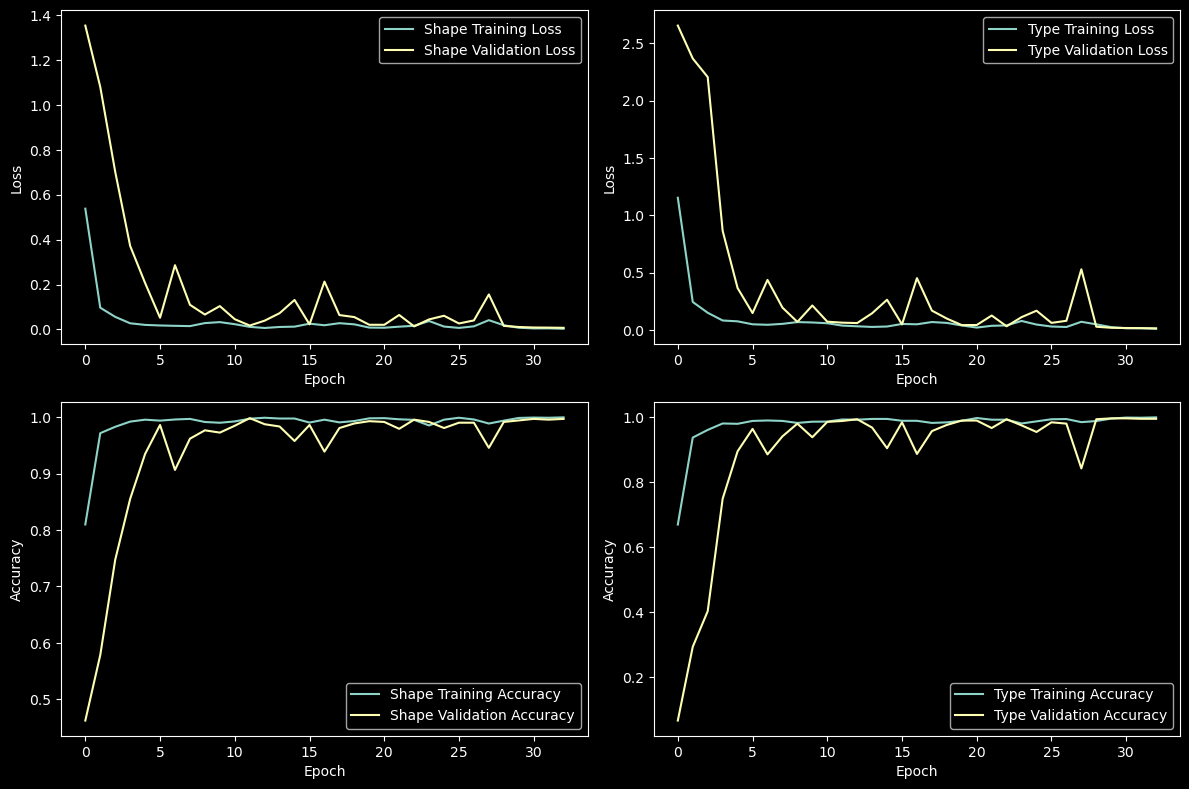

In [123]:
# Plot the learning curves
plt.figure(figsize=(12, 8))

# Plot loss curves
plt.subplot(2, 2, 1)
plt.plot(history.history['shape_loss'], label='Shape Training Loss')
plt.plot(history.history['val_shape_loss'], label='Shape Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['type_loss'], label='Type Training Loss')
plt.plot(history.history['val_type_loss'], label='Type Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curves
plt.subplot(2, 2, 3)
plt.plot(history.history['shape_accuracy'], label='Shape Training Accuracy')
plt.plot(history.history['val_shape_accuracy'], label='Shape Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['type_accuracy'], label='Type Training Accuracy')
plt.plot(history.history['val_type_accuracy'], label='Type Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [58]:
# Evaluate the model on the validation set
val_loss, val_shape_loss, val_type_loss, val_shape_acc, val_type_acc = model.evaluate(val_generator, steps=len(val_indices) // 32)

# Print the validation metrics
print("Validation Loss:", val_loss)
print("Validation Shape Loss:", val_shape_loss)
print("Validation Type Loss:", val_type_loss)
print("Validation Shape Accuracy:", val_shape_acc)
print("Validation Type Accuracy:", val_type_acc)

 7/23 [========>.....................] - ETA: 0s - loss: 0.3264 - shape_loss: 0.1289 - type_loss: 0.1975 - shape_accuracy: 0.9688 - type_accuracy: 0.9598

2024-05-17 14:20:25.945869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 1s 30ms/step - loss: 0.1914 - shape_loss: 0.0664 - type_loss: 0.1251 - shape_accuracy: 0.9837 - type_accuracy: 0.9796
Validation Loss: 0.1914474070072174
Validation Shape Loss: 0.06637994945049286
Validation Type Loss: 0.12506742775440216
Validation Shape Accuracy: 0.9836956262588501
Validation Type Accuracy: 0.979619562625885


<h5 style="color:#D2B4DE; margin-top: 20px;">
<span style="font-size:1.5em;">📈</span> Visualizing and Interpreting Learning Curves:

<span style="font-size:1em;">✔</span> Learning Rate and Epoch Cutoff:

<ul>
<li>Visualizing the learning curves helps us understand the model's learning progress and make informed decisions about the learning rate and the number of epochs.</li>
<li>By monitoring the training and validation loss curves, we can identify the point at which the model starts to overfit or converge. This helps us determine the optimal epoch cutoff point and apply early stopping to prevent overfitting and save computational resources.</li>
</ul>

<span style="font-size:1em;">✔</span> Training and Validation Loss:

<ul>
<li>Plotting the training and validation loss curves side by side allows us to assess the model's performance and generalization ability.</li>
<li>Ideally, we want to see both the training and validation loss decreasing over epochs, indicating that the model is learning and improving its predictions.</li>
<li>If the validation loss starts to increase while the training loss continues to decrease, it suggests that the model is overfitting to the training data and not generalizing well to unseen data. In such cases, early stopping or regularization techniques can be applied to mitigate overfitting.</li>
</ul>

<span style="font-size:1em;">✔</span> Training and Validation Accuracy:

<ul>
<li>Visualizing the training and validation accuracy curves helps us evaluate the model's performance in terms of correct predictions.</li>
<li>We expect the training and validation accuracy to increase over epochs, indicating that the model is learning and improving its classification accuracy.</li>
<li>If the validation accuracy plateaus or starts to decrease while the training accuracy continues to increase, it suggests that the model is memorizing the training data and not generalizing well to unseen data. This is another indication of overfitting, and regularization techniques or early stopping can be employed to address it.</li>
</ul>

<span style="font-size:1em;">✔</span> Interpreting the Curves:

<ul>
<li>By analyzing the learning curves, we gain insights into the model's learning dynamics and can make informed decisions to optimize its performance.</li>
<li>If the training and validation curves converge and reach a satisfactory level of performance, it indicates that the model has learned meaningful patterns and generalizes well to unseen data.</li>
<li>If there is a significant gap between the training and validation curves, it suggests a mismatch between the model's performance on the training data and its generalization ability. This gap can be addressed by techniques such as regularization, increasing the training data, or adjusting the model's complexity.</li>
</ul>
</h5>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">X.3-3 Some Results</h1>

<h5 style="color:#D2B4DE; margin-top: 20px;">
<span style="font-size:1.5em;">🔍</span> Confusion Matrices and Evaluation Metrics:

<span style="font-size:1em;">✔</span> Confusion Matrix:

<ul>
<li>A confusion matrix is a table that visualizes the performance of a classification model by comparing the predicted labels against the actual labels. In an ideal scenario, we look for a strong diagonal line (from top left to bottom right) in the confusion matrix, indicating that the predicted labels match the actual labels.</li>
</ul>

<span style="font-size:1em;">✔</span> Evaluation Metrics:

<ul>
<li>To assess the performance of an n-ary classification model, we utilize several evaluation metrics, including F1 score, accuracy, recall, and precision. These metrics provide insights into different aspects of the model's performance.</li>
</ul>
</h5>

1/1 [==============================] - 0s 87ms/step
Confusion matrices created.
Shape Classification Report:
              precision    recall  f1-score   support

     diamond       0.84      0.79      0.82        73
         hex       0.00      0.00      0.00        10
       round       0.94      0.85      0.89       342
      square       0.81      0.87      0.84       136
    triangle       0.76      0.91      0.83       179

    accuracy                           0.85       740
   macro avg       0.67      0.68      0.67       740
weighted avg       0.85      0.85      0.85       740

Type Classification Report:
                  precision    recall  f1-score   support

         bicycle       0.94      0.56      0.70        52
        continue       0.59      0.90      0.71        39
        crossing       0.64      0.53      0.58        17
         giveway       0.70      0.98      0.82        46
         laneend       1.00      0.39      0.56        28
  limitedtraffic       0.

<Figure size 800x600 with 0 Axes>

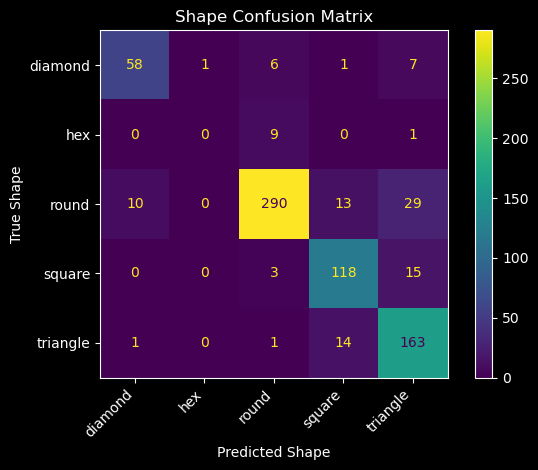

<Figure size 800x600 with 0 Axes>

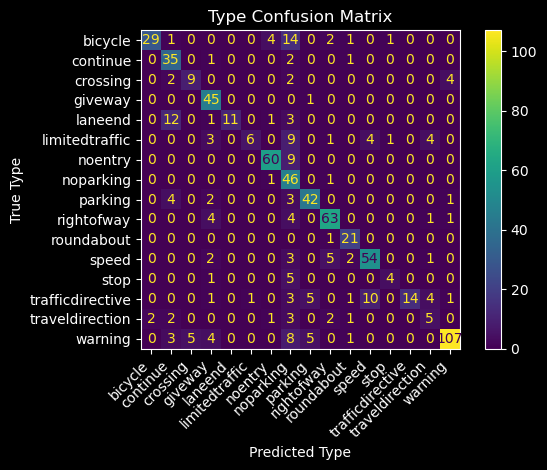

In [100]:
from sklearn.metrics import classification_report

# Initialize empty lists to store the true labels and predicted labels
shape_true_labels = []
type_true_labels = []
shape_pred_labels = []
type_pred_labels = []

# Specify the number of batches to process
num_batches = 24  # Process 24 batches (740 images with batch size 32)

# Iterate over the validation data in batches
batch_count = 0
for batch_data, batch_labels in val_generator:
    # Generate predictions for the current batch
    batch_preds = model.predict(batch_data)
    shape_preds = np.argmax(batch_preds[0], axis=1)
    type_preds = np.argmax(batch_preds[1], axis=1)

    # Append the true labels and predicted labels to the lists
    shape_true_labels.extend(batch_labels[0])
    type_true_labels.extend(batch_labels[1])
    shape_pred_labels.extend(shape_preds)
    type_pred_labels.extend(type_preds)

    batch_count += 1
    if batch_count >= num_batches:
        break  # Exit the loop after processing the specified number of batches

# Map the predicted labels back to their original names
shape_labels_map = {i: label for i, label in enumerate(shape_encoder.classes_)}
type_labels_map = {i: label for i, label in enumerate(type_encoder.classes_)}

# Create confusion matrices for shape and type
shape_cm = confusion_matrix(shape_true_labels, shape_pred_labels)
type_cm = confusion_matrix(type_true_labels, type_pred_labels)

print("Confusion matrices created.")

# Generate classification reports for shape and type
shape_report = classification_report(shape_true_labels, shape_pred_labels, target_names=shape_encoder.classes_)
type_report = classification_report(type_true_labels, type_pred_labels, target_names=type_encoder.classes_)

print("Shape Classification Report:")
print(shape_report)

print("Type Classification Report:")
print(type_report)

# Plot the confusion matrix for shape
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot()
plt.title("Shape Confusion Matrix")
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot the confusion matrix for type
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot()
plt.title("Type Confusion Matrix")
plt.xlabel("Predicted Type")
plt.ylabel("True Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 68ms/step


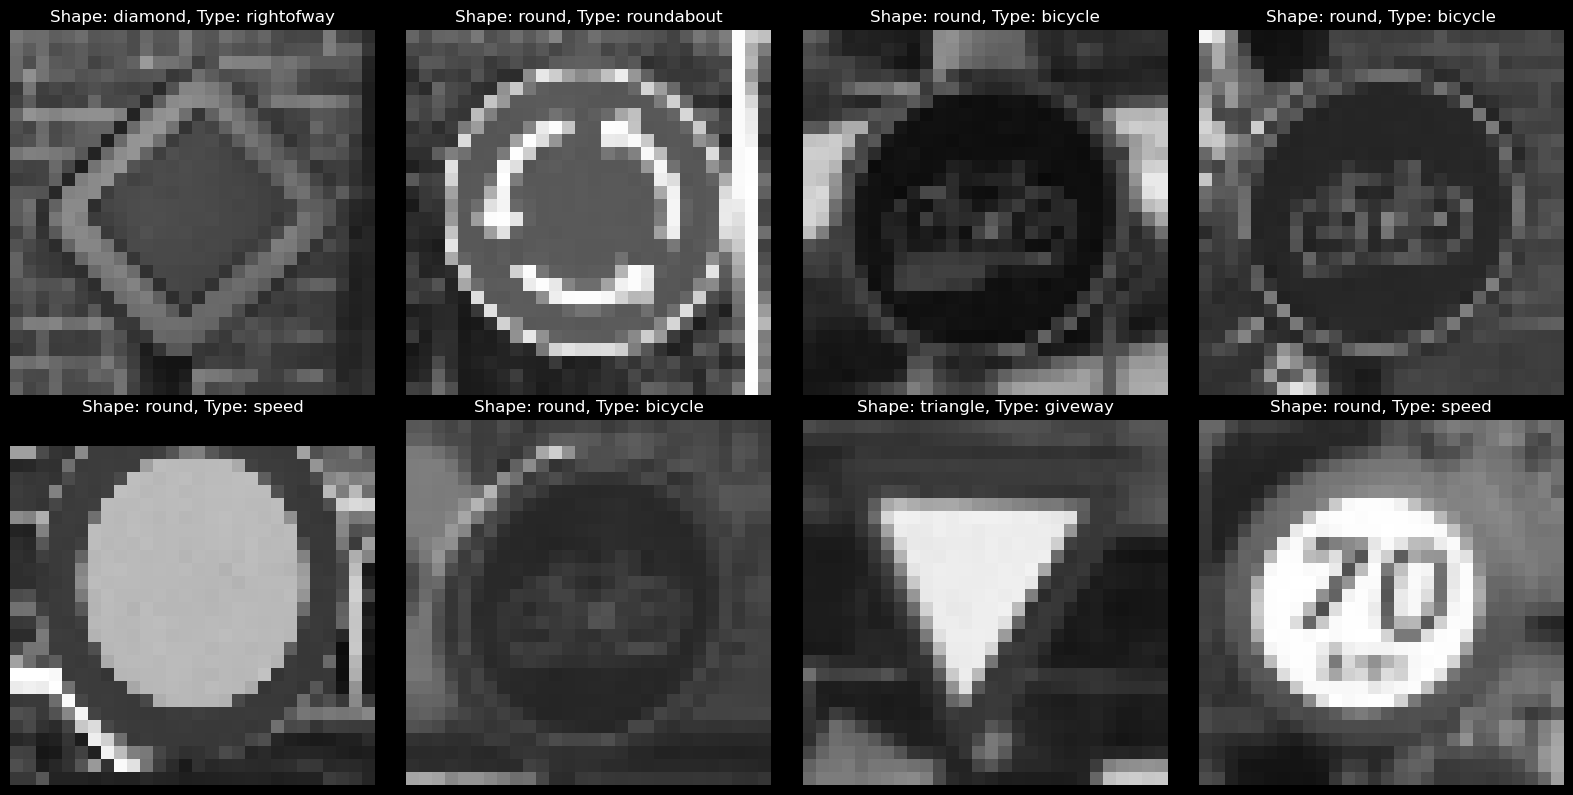

In [33]:
# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# Loop through 8 random examples
for i in range(8):
    # Select a random image path from the validation set
    random_index = np.random.choice(val_indices)
    image_path = df.iloc[random_index]['image_path']
    
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Make predictions
    shape_pred, type_pred = model.predict(x)
    
    # Get the predicted shape and type labels
    shape_label = shape_encoder.inverse_transform([np.argmax(shape_pred)])[0]
    type_label = type_encoder.inverse_transform([np.argmax(type_pred)])[0]
    
    # Display the tested image
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Shape: {shape_label}, Type: {type_label}")

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">X.3-3 Model Parameters & Details</h1>

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 flatten (Flatten)              (None, 2352)         0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 128)          301184      ['flatten[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                                                              

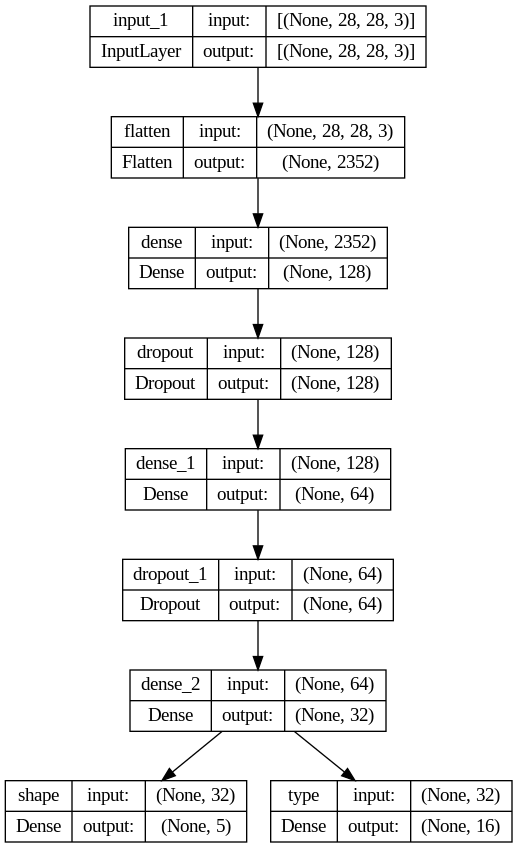

In [35]:
tf.keras.utils.plot_model(model, show_shapes=True)

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">X.3-3 Save the Model!</h1>

In [36]:
model.save("model")

2024-05-17 13:26:31.208096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2024-05-17 13:26:31.217922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2024-05-17 13:26:31.377114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2024-05-17 13:26:

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">Independent Evaluation</h1>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">X.3-3 Domain Expert</h1>

In [37]:
We consulted 

SyntaxError: invalid syntax (3932103081.py, line 1)

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">X.3-3 Sourcing Methodology</h1>

In [ ]:
-BEST IDEA IS TO GATHER INCORRECT, AND CORRECT DATA TO TEST.
we used both the german sister dataset, and collected 200 of our own images
Oisin has a iPhone 12
Vince has a iPhone 13
https://istyle.ae/blog/camera-comparison-iphone-12-vs-iphone-13-camera

In [38]:
print("\nValidation set counts:")
print("Shape labels:")
print(df.loc[val_indices, 'shape_label'].map(dict(enumerate(shape_labels))).value_counts())
print("\nType labels:")
print(df.loc[val_indices, 'type_label'].map(dict(enumerate(type_labels))).value_counts())


Validation set counts:
Shape labels:
shape_label
round       342
triangle    179
square      136
diamond      73
hex          10
Name: count, dtype: int64

Type labels:
type_label
warning             133
rightofway           73
noentry              69
speed                67
parking              52
bicycle              52
noparking            48
giveway              46
trafficdirective     40
continue             39
laneend              28
limitedtraffic       28
roundabout           22
crossing             17
traveldirection      16
stop                 10
Name: count, dtype: int64


<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">X.3-3 Pre-processing</h1>

In [39]:
def process_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Get the file extension
            _, extension = os.path.splitext(file)

            # Check if the file is an image
            if extension.lower() in ['.png', '.ppm']:
                # Construct the full file paths
                input_path = os.path.join(root, file)
                output_path = os.path.join(root, os.path.splitext(file)[0] + '.png')

                try:
                    # Open the image file
                    with Image.open(input_path) as img:
                        # Convert the image to grayscale
                        grayscale_img = img.convert('L')

                        # Resize the grayscale image to 28x28 pixels
                        resized_img = grayscale_img.resize((28, 28))

                        # Save the processed image as PNG, using the new file extension
                        resized_img.save(output_path)

                        # Check if the original file is a .ppm file
                        if extension.lower() == '.ppm':
                            # Delete the original .ppm file
                            os.remove(input_path)

                except Exception as e:
                    print(f"Error processing {input_path}: {str(e)}")

# Directory to start the recursive processing
directory = "independent_dataset"

# Call the function to process and save the images
process_images(directory)

In [24]:
in order to properly test the test data it must be in the same format (28x28 greyscale). to achieve this we run a custom script we made that pre-processes all .png images that haven't already been processed by first converting them to 28x28, and then to greyscale.

we then perform a similar EDA as done previously to ensure, and check for any anomalies.

SyntaxError: invalid decimal literal (679789304.py, line 1)

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">X.3-3 Independent Evaluation Ingestion</h1>

In [40]:
# Directory containing the image dataset
dataset_dir = 'independent_dataset'

# Function to get all image files in subdirectories
def get_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png')):
                image_files.append(os.path.join(root, file))
    return image_files

# Get the list of image files
image_files = get_image_files(dataset_dir)
print("Number of image files found:", len(image_files))

# Initialize lists to store image properties
image_sizes = []
image_formats = []
image_colors = []
image_sharpness = []
pixel_intensities = []
entropies = []
image_similarities = []
image_data = []

# Iterate over the image files
for image_path in image_files:
    try:
        image = io.imread(image_path, as_gray=True)
        
        # Get image size
        height, width = image.shape
        image_sizes.append((width, height))
        
        # Get image format
        image_format = os.path.splitext(image_path)[1][1:]
        image_formats.append(image_format)
        
        # Check if the image is grayscale or color
        if len(image.shape) == 2:
            image_colors.append('grayscale')
        else:
            image_colors.append('color')
        
        # Calculate image sharpness using the variance of the Laplacian
        sharpness = np.var(filters.laplace(image))
        image_sharpness.append(sharpness)
        
        # Calculate average pixel intensity
        pixel_intensity = np.mean(image)
        pixel_intensities.append(pixel_intensity)
        
        # Calculate image entropy
        entropy = measure.shannon_entropy(image)
        entropies.append(entropy)
        
        # Store image data for similarity calculation
        image_data.append(image.flatten())
        
        # Domain-specific analysis for road sign classification/shape
        # Example: Extract shape features using Hu moments
        moments = measure.moments_hu(image)
        # Perform further analysis or classification based on the extracted features
        
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")

# Calculate image similarities
for i, img1 in enumerate(image_data):
    if i == 0:
        image_similarities.append(0)
    else:
        distances = [euclidean(img1, img2) for img2 in image_data[:i]]
        image_similarities.append(np.min(distances))

Number of image files found: 689


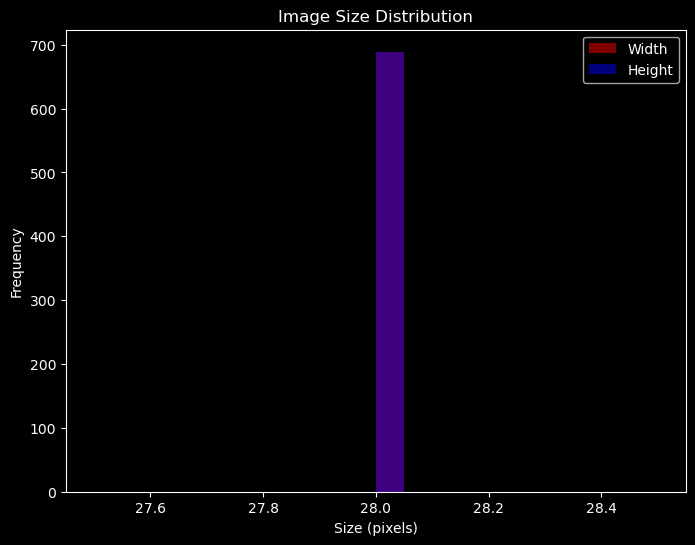

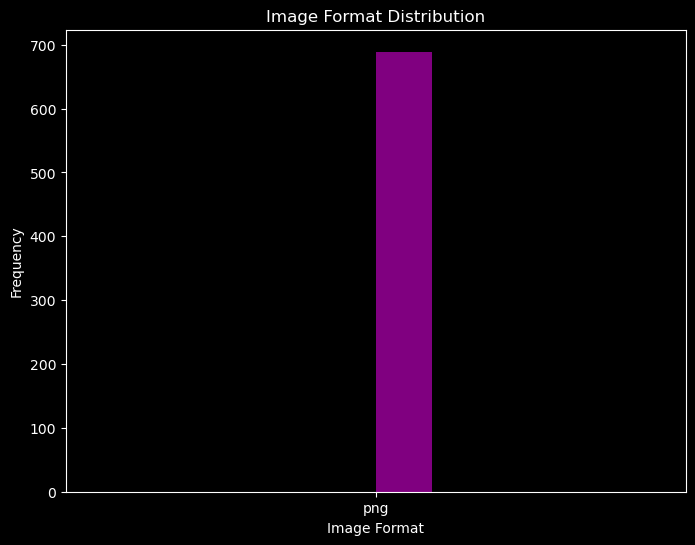

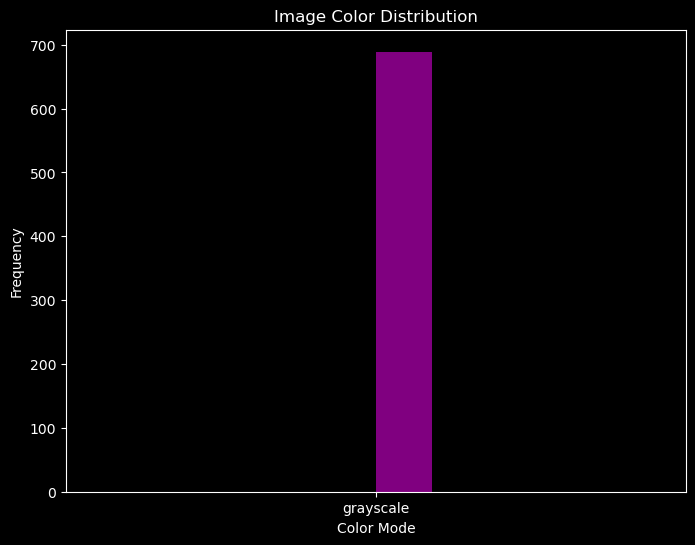

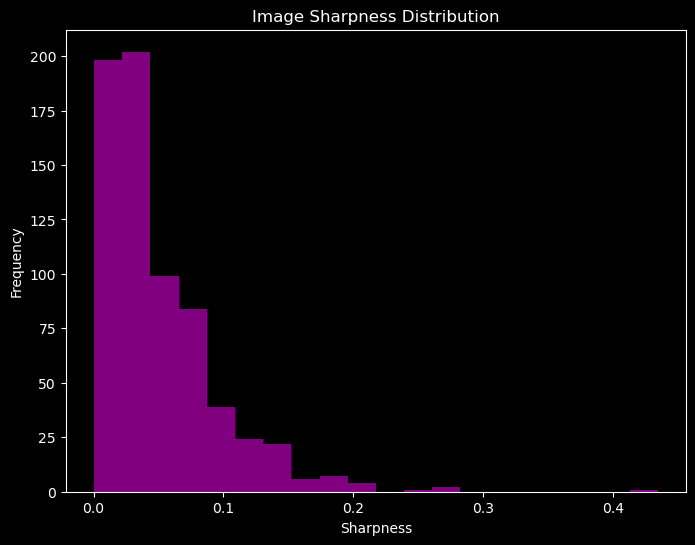

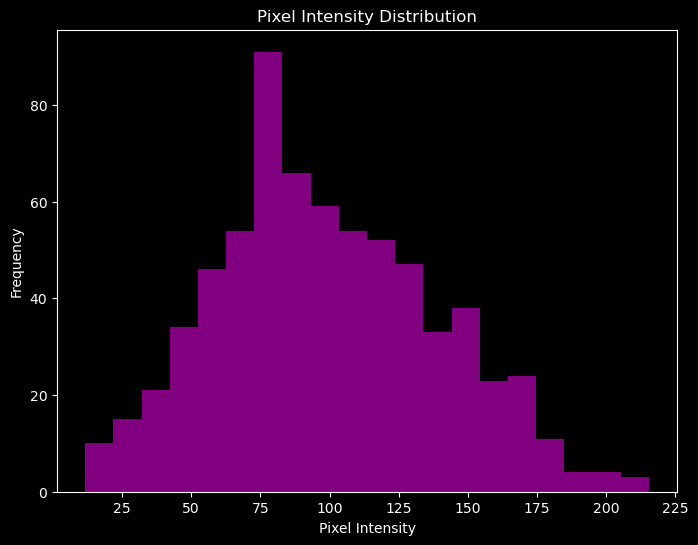

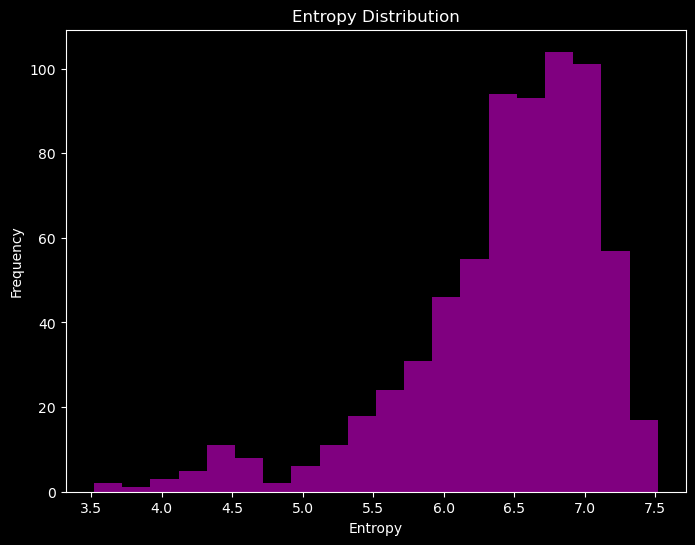

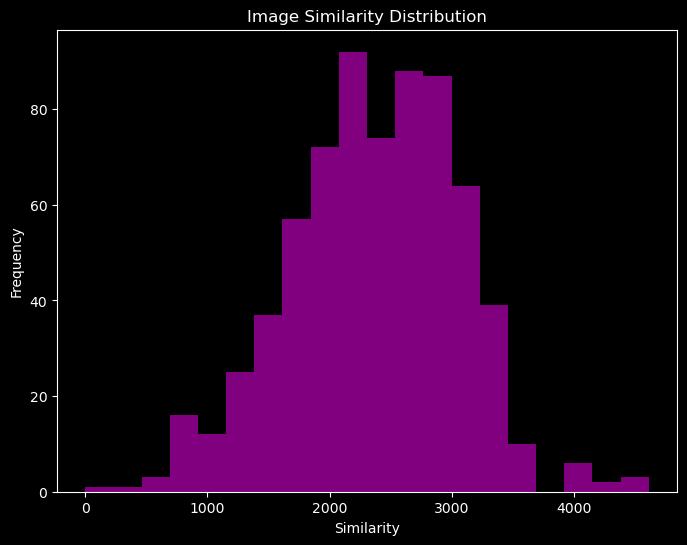

In [41]:
# Plot image size distribution
plt.figure(figsize=(8, 6))
plt.hist([size[0] for size in image_sizes], bins=20, alpha=0.5, color='red', label='Width')
plt.hist([size[1] for size in image_sizes], bins=20, alpha=0.5, color='blue', label='Height')
plt.xlabel('Size (pixels)')
plt.ylabel('Frequency')
plt.title('Image Size Distribution')
plt.legend()
plt.show()

# Plot image format distribution
plt.figure(figsize=(8, 6))
plt.hist(image_formats, color='purple')
plt.xlabel('Image Format')
plt.ylabel('Frequency')
plt.title('Image Format Distribution')
plt.show()

# Plot image color distribution
plt.figure(figsize=(8, 6))
plt.hist(image_colors, color='purple')
plt.xlabel('Color Mode')
plt.ylabel('Frequency')
plt.title('Image Color Distribution')
plt.show()

# Plot image sharpness distribution
plt.figure(figsize=(8, 6))
plt.hist(image_sharpness, bins=20, color='purple')
plt.xlabel('Sharpness')
plt.ylabel('Frequency')
plt.title('Image Sharpness Distribution')
plt.show()

# Plot pixel intensity distribution
plt.figure(figsize=(8, 6))
plt.hist(pixel_intensities, bins=20, color='purple')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()

# Plot entropy distribution
plt.figure(figsize=(8, 6))
plt.hist(entropies, bins=20, color='purple')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Entropy Distribution')
plt.show()

# Plot image similarity distribution
plt.figure(figsize=(8, 6))
plt.hist(image_similarities, bins=20, color='purple')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Image Similarity Distribution')
plt.show()

In [60]:
note to run this cell you must run the previous data leakage cell

SyntaxError: invalid syntax (3092820251.py, line 1)

In [103]:
test_dataset_path = 'independent_dataset'
img_size = (28, 28)
# img_size = (32, 32) # for transfer learning

Number of images in the test set: 689


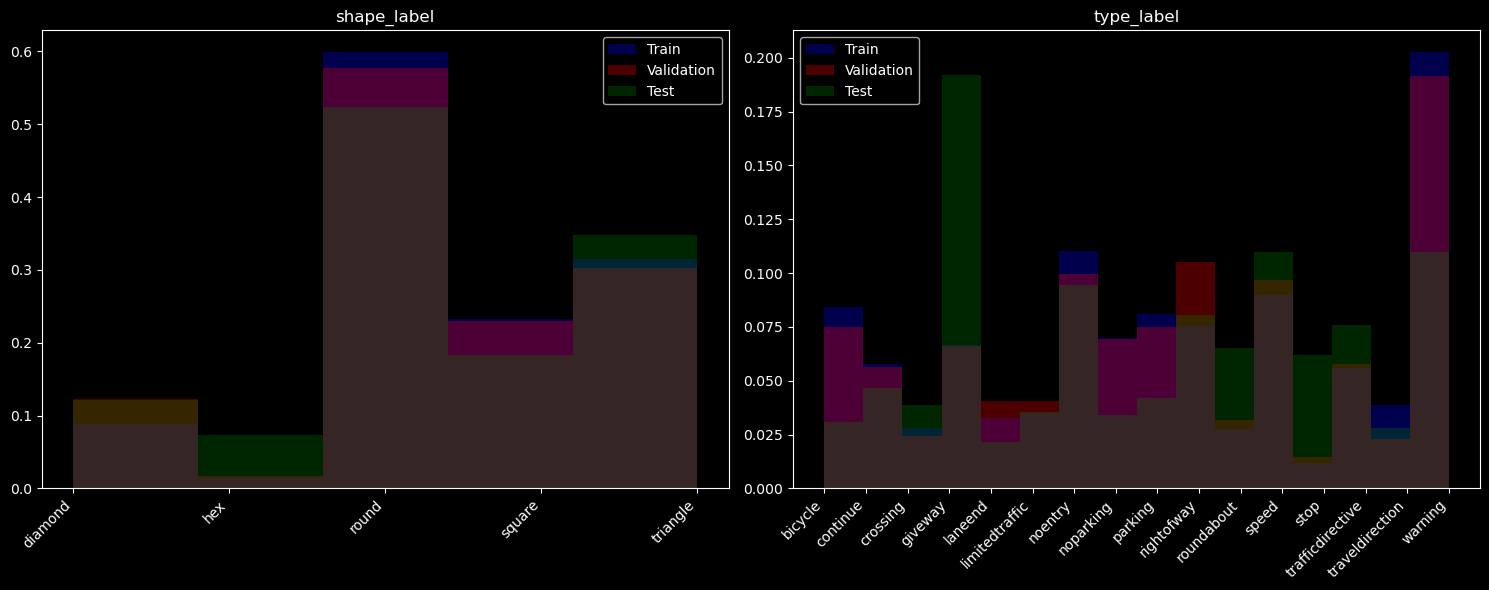

In [104]:
# Create lists to store the image paths, shapes, and types for the test dataset
test_image_paths = []
test_shapes = []
test_types = []

for shape in os.listdir(test_dataset_path):
    shape_path = os.path.join(test_dataset_path, shape)
    for sign_type in os.listdir(shape_path):
        type_path = os.path.join(shape_path, sign_type)
        for image_file in os.listdir(type_path):
            image_path = os.path.join(type_path, image_file)
            test_image_paths.append(image_path)
            test_shapes.append(shape)
            test_types.append(sign_type)

# Encode the shape and type labels for the test dataset
test_shape_labels = shape_encoder.transform(test_shapes)
test_type_labels = type_encoder.transform(test_types)

# Create a DataFrame with image paths, shape labels, and type labels for the test dataset
test_df = pd.DataFrame({
    'image_path': test_image_paths,
    'shape_label': test_shape_labels,
    'type_label': test_type_labels
})

# Print the number of items in the test dataset
print("Number of images in the test set:", len(test_df))

# Create a data generator for the test dataset
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Update the histogram plotting code to include the test dataset
plt.figure(figsize=(15, 6))
for i, col in enumerate(['shape_label', 'type_label']):
    plt.subplot(1, 2, i+1)
    if col == 'shape_label':
        unique_values = shape_labels
    else:
        unique_values = type_labels
    plt.hist(df.loc[train_indices, col], alpha=0.3, color='b', density=True,
             bins=len(unique_values), label='Train')
    plt.hist(df.loc[val_indices, col], alpha=0.3, color='r', density=True,
             bins=len(unique_values), label='Validation')
    plt.hist(test_df[col], alpha=0.3, color='g', density=True,
             bins=len(unique_values), label='Test')
    plt.title(col)
    plt.xticks(range(len(unique_values)), unique_values, rotation=45, ha='right')
    plt.legend()

plt.tight_layout()
plt.show()

22/22 [==============================] - 0s 14ms/step
Confusion matrices created for subcategory: all
Classification Report - Shape (all):
              precision    recall  f1-score   support

     diamond       0.78      0.75      0.76        67
         hex       1.00      0.47      0.64        40
       round       0.85      0.83      0.84       289
      square       0.89      0.82      0.86       101
    triangle       0.78      0.94      0.85       192

    accuracy                           0.83       689
   macro avg       0.86      0.76      0.79       689
weighted avg       0.84      0.83      0.83       689

Classification Report - Type (all):
                  precision    recall  f1-score   support

         bicycle       0.33      0.45      0.38        20
        continue       0.97      1.00      0.98        30
        crossing       0.93      0.56      0.70        25
         giveway       0.96      0.94      0.95       124
         laneend       0.93      1.00      0.

<Figure size 800x600 with 0 Axes>

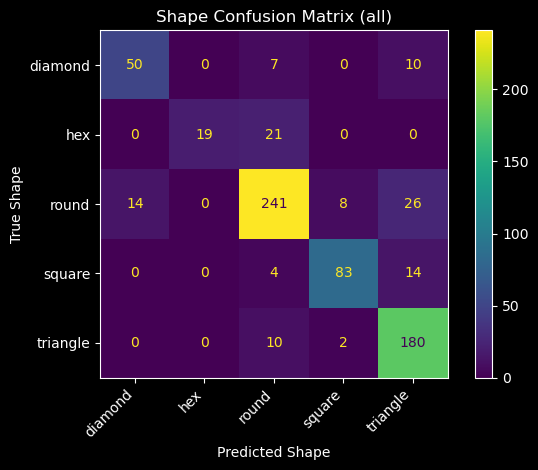

<Figure size 800x600 with 0 Axes>

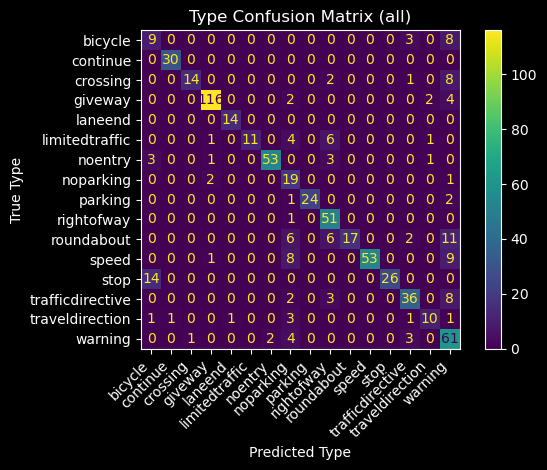

3/3 [==============================] - 0s 10ms/step
Confusion matrices created for subcategory: australian
Classification Report - Shape (australian):
              precision    recall  f1-score   support

     diamond       0.50      0.07      0.12        15
         hex       1.00      0.71      0.83         7
       round       0.42      0.42      0.42        19
      square       1.00      0.06      0.11        18
    triangle       0.22      1.00      0.36         9

    accuracy                           0.35        68
   macro avg       0.63      0.45      0.37        68
weighted avg       0.62      0.35      0.30        68

Classification Report - Type (australian):
                  precision    recall  f1-score   support

         bicycle       0.00      0.00      0.00        11
        crossing       0.00      0.00      0.00        11
         giveway       0.00      0.00      0.00         4
         noentry       0.86      0.86      0.86         7
       noparking       0.0

<Figure size 800x600 with 0 Axes>

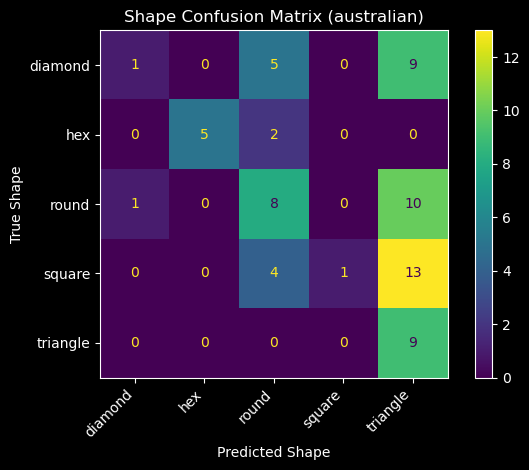

<Figure size 800x600 with 0 Axes>

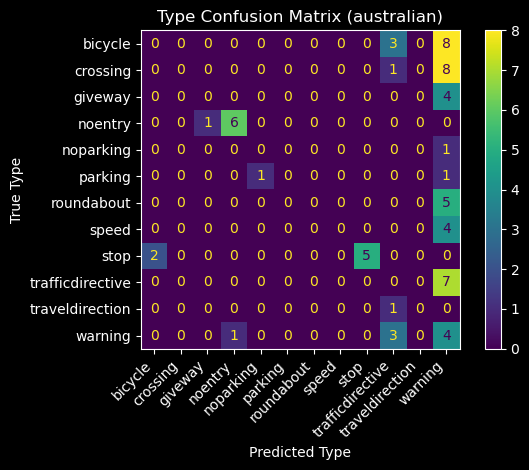

4/4 [==============================] - 0s 11ms/step
Confusion matrices created for subcategory: belgium
Classification Report - Shape (belgium):
              precision    recall  f1-score   support

     diamond       1.00      1.00      1.00         2
       round       1.00      0.96      0.98        23
      square       1.00      0.99      0.99        77
    triangle       0.67      1.00      0.80         4

    accuracy                           0.98       106
   macro avg       0.92      0.99      0.94       106
weighted avg       0.99      0.98      0.98       106

Classification Report - Type (belgium):
                precision    recall  f1-score   support

       bicycle       1.00      1.00      1.00         9
      continue       1.00      1.00      1.00        30
      crossing       1.00      1.00      1.00         8
       giveway       1.00      1.00      1.00         1
       laneend       1.00      1.00      1.00        14
limitedtraffic       1.00      1.00      1.

<Figure size 800x600 with 0 Axes>

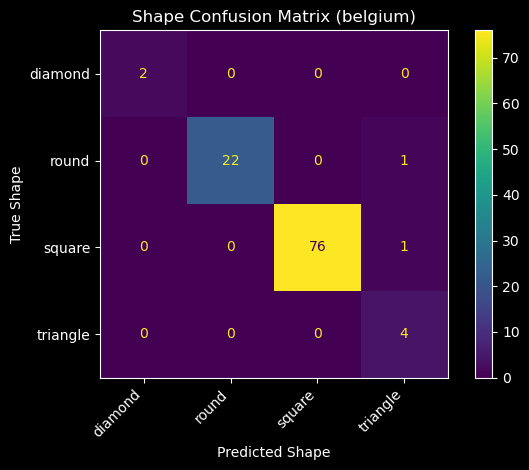

<Figure size 800x600 with 0 Axes>

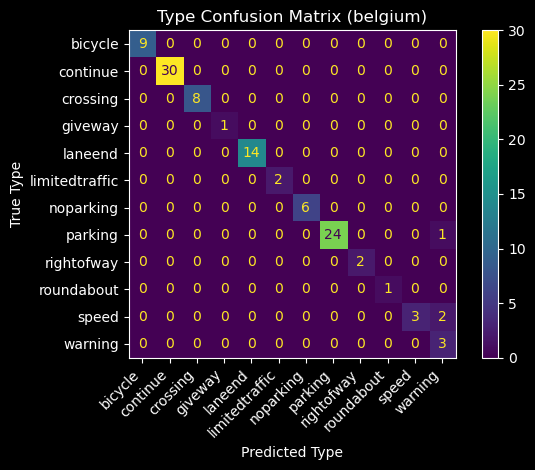

16/16 [==============================] - 0s 18ms/step
Confusion matrices created for subcategory: german
Classification Report - Shape (german):
              precision    recall  f1-score   support

     diamond       0.78      0.94      0.85        50
         hex       1.00      0.42      0.60        33
       round       0.87      0.85      0.86       243
      square       0.38      1.00      0.55         6
    triangle       0.91      0.93      0.92       179

    accuracy                           0.86       511
   macro avg       0.79      0.83      0.76       511
weighted avg       0.88      0.86      0.86       511

Classification Report - Type (german):
                  precision    recall  f1-score   support

        crossing       0.86      1.00      0.92         6
         giveway       0.97      0.97      0.97       119
  limitedtraffic       1.00      0.43      0.60        21
         noentry       0.98      0.86      0.91        50
       noparking       0.30      0.8

<Figure size 800x600 with 0 Axes>

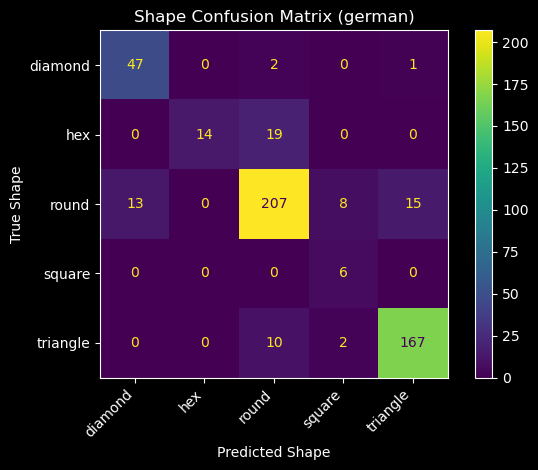

<Figure size 800x600 with 0 Axes>

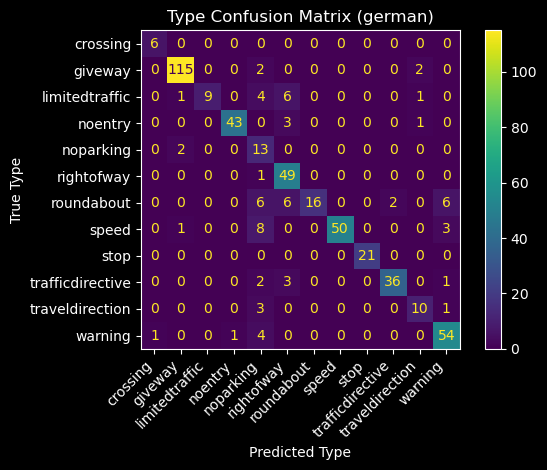

In [125]:
def generate_confusion_matrices(subcategory):
    # Load the test image data based on the subcategory
    if subcategory == 'all':
        X_test = np.array([img_to_array(load_img(path, target_size=img_size)) / 255.0 for path in test_df['image_path']])
        shape_true_labels = test_df['shape_label'].values
        type_true_labels = test_df['type_label'].values
    elif subcategory == 'australian':
        X_test = np.array([img_to_array(load_img(path, target_size=img_size)) / 255.0 for path in test_df[test_df['image_path'].str.contains('australian')]['image_path']])
        shape_true_labels = test_df[test_df['image_path'].str.contains('australian')]['shape_label'].values
        type_true_labels = test_df[test_df['image_path'].str.contains('australian')]['type_label'].values
    elif subcategory == 'belgium':
        X_test = np.array([img_to_array(load_img(path, target_size=img_size)) / 255.0 for path in test_df[test_df['image_path'].str.contains('belgium')]['image_path']])
        shape_true_labels = test_df[test_df['image_path'].str.contains('belgium')]['shape_label'].values
        type_true_labels = test_df[test_df['image_path'].str.contains('belgium')]['type_label'].values
    elif subcategory == 'german':
        X_test = np.array([img_to_array(load_img(path, target_size=img_size)) / 255.0 for path in test_df[test_df['image_path'].str.contains('german')]['image_path']])
        shape_true_labels = test_df[test_df['image_path'].str.contains('german')]['shape_label'].values
        type_true_labels = test_df[test_df['image_path'].str.contains('german')]['type_label'].values
    else:
        raise ValueError(f"Invalid subcategory: {subcategory}")

    # Generate predictions for the test data
    test_preds = model.predict(X_test)
    shape_preds = np.argmax(test_preds[0], axis=1)
    type_preds = np.argmax(test_preds[1], axis=1)

    # Get the unique shape and type labels present in the subset of data
    shape_labels = np.unique(shape_true_labels)
    type_labels = np.unique(type_true_labels)

    # Map the predicted labels to their original names based on the subset of data
    shape_labels_map = {label: shape_encoder.inverse_transform([label])[0] for label in shape_labels}
    type_labels_map = {label: type_encoder.inverse_transform([label])[0] for label in type_labels}

    # Create confusion matrices for shape and type
    shape_cm = confusion_matrix(shape_true_labels, shape_preds, labels=shape_labels)
    type_cm = confusion_matrix(type_true_labels, type_preds, labels=type_labels)

    print(f"Confusion matrices created for subcategory: {subcategory}")

    # Generate classification report for shape
    print(f"Classification Report - Shape ({subcategory}):")
    print(classification_report(shape_true_labels, shape_preds, labels=shape_labels, target_names=[shape_labels_map[label] for label in shape_labels]))

    # Generate classification report for type
    print(f"Classification Report - Type ({subcategory}):")
    print(classification_report(type_true_labels, type_preds, labels=type_labels, target_names=[type_labels_map[label] for label in type_labels]))

    # Plot the confusion matrix for shape
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay(shape_cm, display_labels=[shape_labels_map[label] for label in shape_labels]).plot()
    plt.title(f"Shape Confusion Matrix ({subcategory})")
    plt.xlabel("Predicted Shape")
    plt.ylabel("True Shape")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Plot the confusion matrix for type
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay(type_cm, display_labels=[type_labels_map[label] for label in type_labels]).plot()
    plt.title(f"Type Confusion Matrix ({subcategory})")
    plt.xlabel("Predicted Type")
    plt.ylabel("True Type")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Generate confusion matrices for different subcategories
generate_confusion_matrices('all')
generate_confusion_matrices('australian')
generate_confusion_matrices('belgium')
generate_confusion_matrices('german')

1/1 [==============================] - 0s 49ms/step


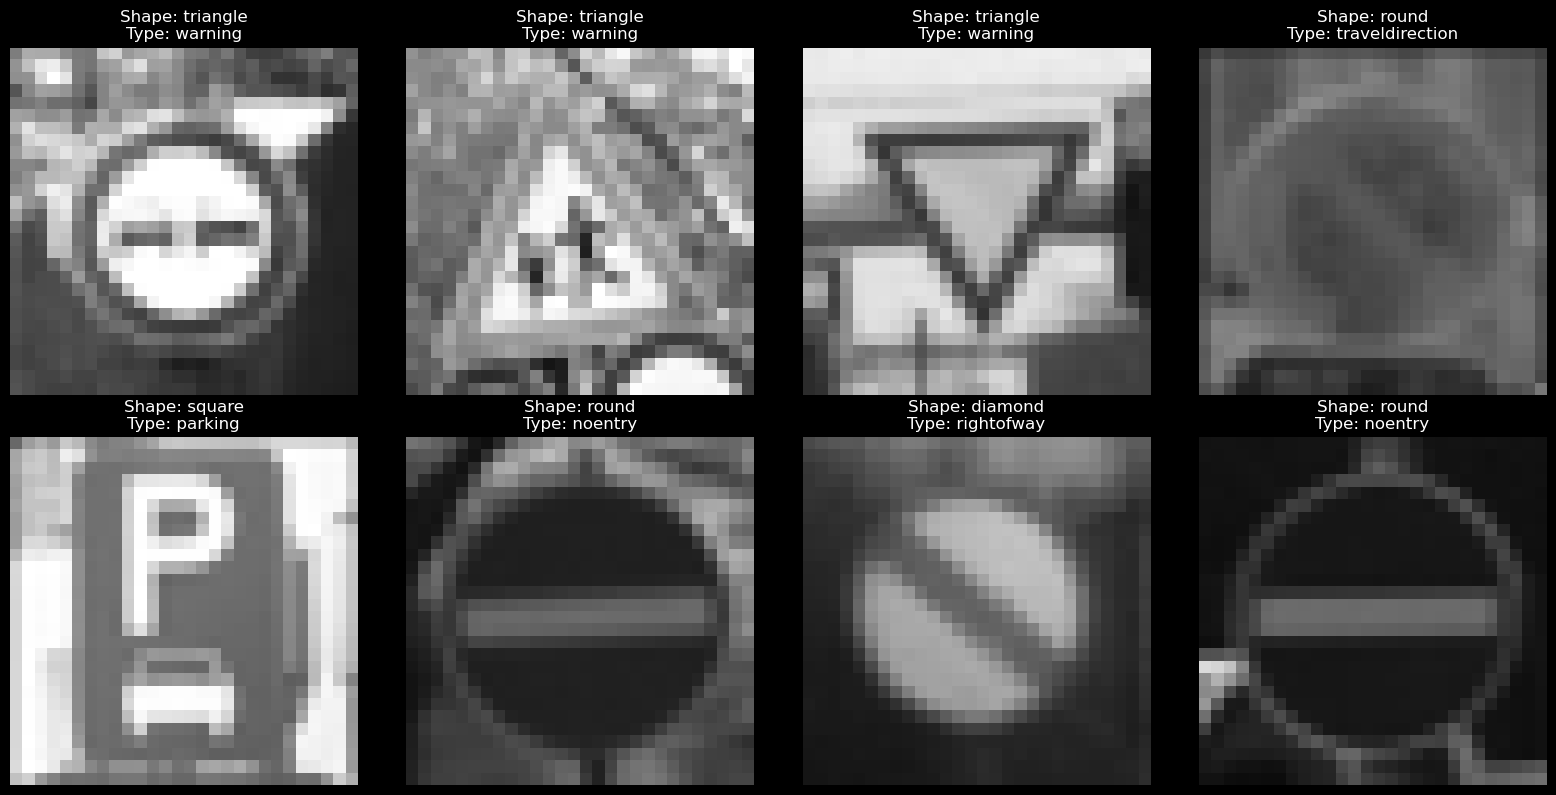

In [45]:
# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, ax in enumerate(axes.flat):
    # Get the file path of a random test image
    random_index = np.random.randint(len(test_df))
    image_path = test_df.iloc[random_index]['image_path']
    
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    # Make predictions
    shape_pred, type_pred = model.predict(x)
    shape_label = shape_encoder.inverse_transform([np.argmax(shape_pred)])[0]
    type_label = type_encoder.inverse_transform([np.argmax(type_pred)])[0]
    
    # Display the image and predicted labels
    ax.imshow(img)
    ax.set_title(f'Shape: {shape_label}\nType: {type_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 73ms/step


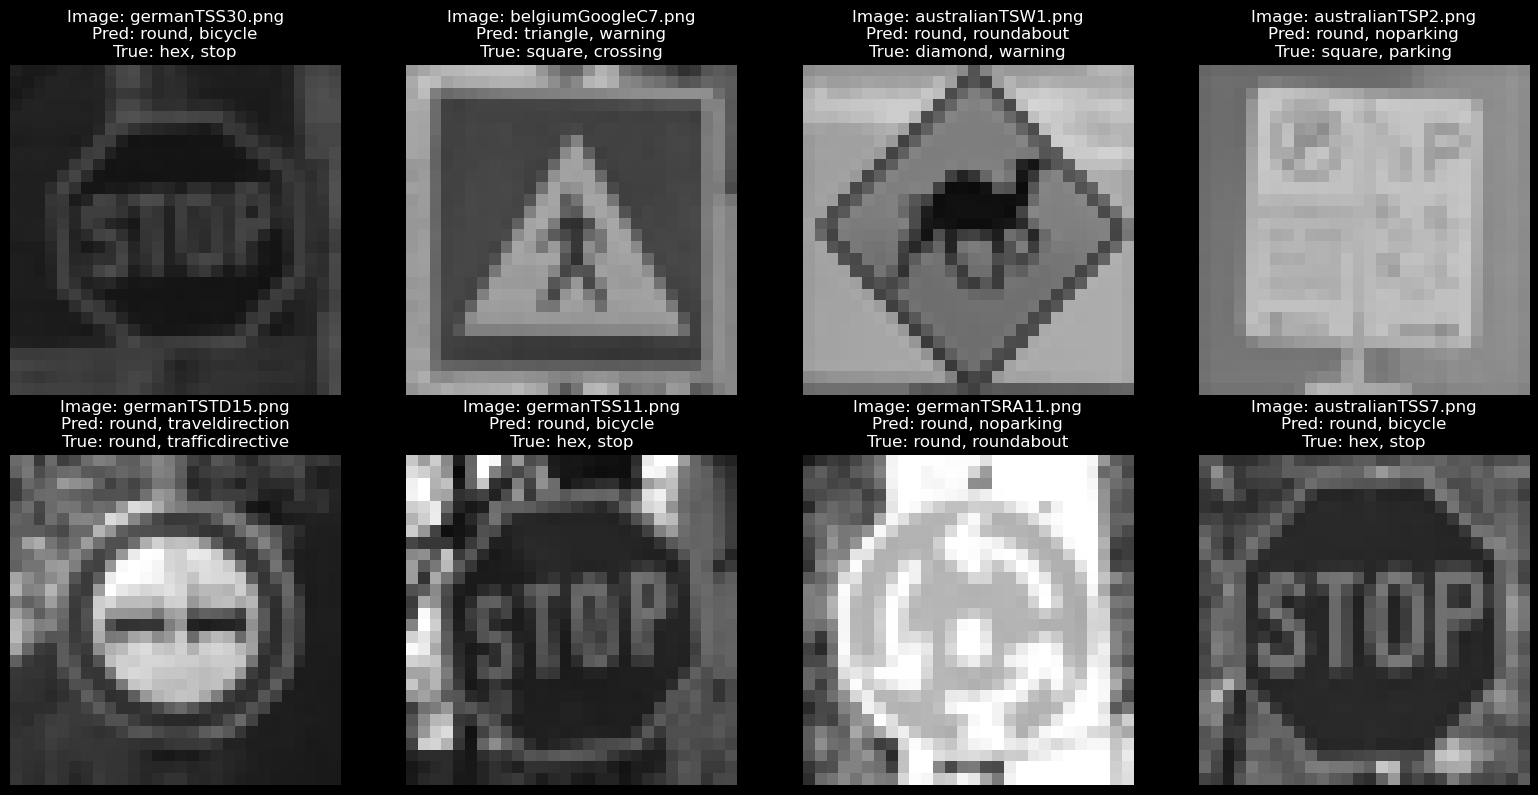

In [46]:
# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# Initialize a counter for wrongly classified images
wrong_counter = 0

# Loop until we find 8 wrongly classified images
while wrong_counter < 8:
    # Select a random image path from the test set
    random_index = np.random.choice(len(test_df))
    image_path = test_df.iloc[random_index]['image_path']
    
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Make predictions
    preds = model.predict(x)
    shape_pred = preds[0]
    type_pred = preds[1]
    
    # Get the predicted shape and type labels
    shape_label = shape_encoder.inverse_transform([np.argmax(shape_pred)])[0]
    type_label = type_encoder.inverse_transform([np.argmax(type_pred)])[0]
    
    # Get the true shape and type labels
    true_shape_label = shape_encoder.inverse_transform([test_df.iloc[random_index]['shape_label']])[0]
    true_type_label = type_encoder.inverse_transform([test_df.iloc[random_index]['type_label']])[0]
    
    # Check if the predicted labels match the true labels
    if shape_label != true_shape_label or type_label != true_type_label:
        # Extract the image name from the image path
        image_name = os.path.basename(image_path)
        
        # Display the wrongly classified image with the image name
        axes[wrong_counter].imshow(img)
        axes[wrong_counter].axis('off')
        axes[wrong_counter].set_title(f"Image: {image_name}\nPred: {shape_label}, {type_label}\nTrue: {true_shape_label}, {true_type_label}")
        wrong_counter += 1

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

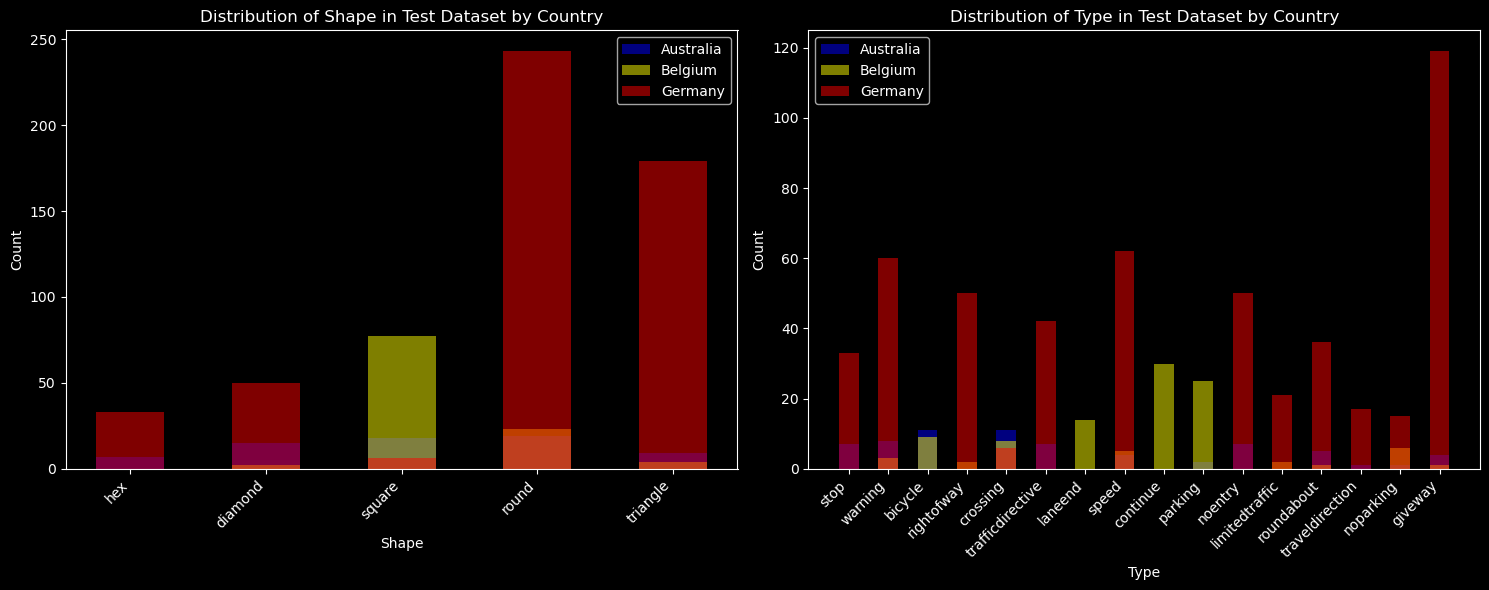

In [47]:
# Create lists to store the image paths, shapes, types, and countries for the test dataset
test_image_paths = []
test_shapes = []
test_types = []
test_countries = []

for shape in os.listdir(test_dataset_path):
    shape_path = os.path.join(test_dataset_path, shape)
    for sign_type in os.listdir(shape_path):
        type_path = os.path.join(shape_path, sign_type)
        for image_file in os.listdir(type_path):
            image_path = os.path.join(type_path, image_file)
            test_image_paths.append(image_path)
            test_shapes.append(shape)
            test_types.append(sign_type)
            if 'australian' in image_path:
                test_countries.append('Australia')
            elif 'belgium' in image_path:
                test_countries.append('Belgium')
            elif 'german' in image_path:
                test_countries.append('Germany')
            else:
                test_countries.append('Other')

# Create a DataFrame with image paths, shapes, types, and countries for the test dataset
test_df = pd.DataFrame({
    'image_path': test_image_paths,
    'shape': test_shapes,
    'type': test_types,
    'country': test_countries
})

# Set the height of the bars
bar_height = 0.5

# Plot the histograms for shapes and types based on country
plt.figure(figsize=(15, 6))
for i, col in enumerate(['shape', 'type']):
    plt.subplot(1, 2, i+1)

    # Get the unique values for the current column
    unique_values = test_df[col].unique()

    # Set the positions of the bars on the x-axis
    x = np.arange(len(unique_values))

    # Plot the histograms for each country
    country_colors = {
        'Australia': 'blue',
        'Belgium': 'yellow',
        'Germany': 'red'
    }
    for j, country in enumerate(['Australia', 'Belgium', 'Germany']):
        counts = test_df[test_df['country'] == country][col].value_counts()
        counts = counts.reindex(unique_values, fill_value=0)
        plt.bar(x, counts, width=bar_height, color=country_colors[country], alpha=0.5, label=country)

    plt.title(f'Distribution of {col.capitalize()} in Test Dataset by Country')
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    plt.xticks(x, unique_values, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()

plt.show()

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">X.1 Comparing to non neural network models</h1>

Confusion matrices created.
Classification Report - Shape:
              precision    recall  f1-score   support

     diamond       0.73      0.28      0.41        67
         hex       0.17      0.03      0.04        40
       round       0.64      0.96      0.77       289
      square       0.70      0.50      0.58       101
    triangle       0.86      0.70      0.77       192

    accuracy                           0.70       689
   macro avg       0.62      0.49      0.52       689
weighted avg       0.69      0.70      0.67       689

Classification Report - Type:
                  precision    recall  f1-score   support

         bicycle       0.15      0.45      0.23        20
        continue       0.83      0.80      0.81        30
        crossing       1.00      0.20      0.33        25
         giveway       0.90      0.53      0.67       124
         laneend       1.00      0.57      0.73        14
  limitedtraffic       0.47      0.74      0.58        23
         noentr

<Figure size 800x600 with 0 Axes>

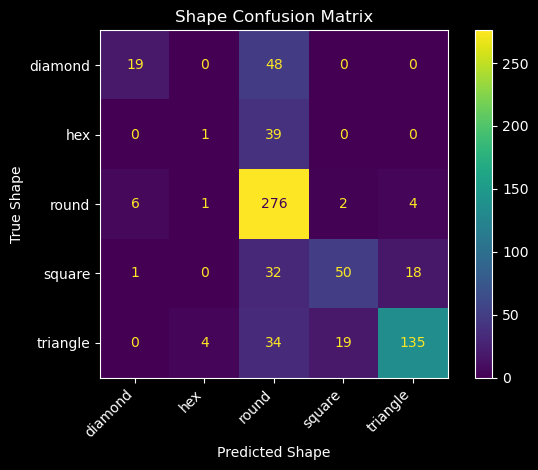

<Figure size 800x600 with 0 Axes>

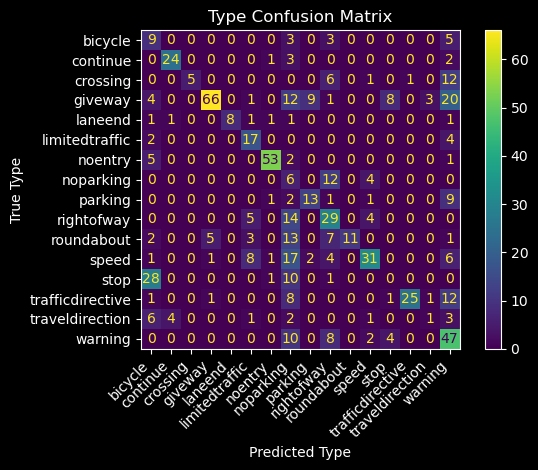

In [55]:
# Initialize empty lists to store the true labels and predicted labels
shape_true_labels = []
type_true_labels = []
shape_pred_labels = []
type_pred_labels = []

# Load and preprocess the test images
test_images = []
for image_path in test_df['image_path']:
    img = imageio.imread(image_path)
    img = img / 255.0
    test_images.append(img.flatten())

test_images = np.array(test_images)

# Get the true labels for the test images
test_shape_labels = test_df['shape_label'].values
test_type_labels = test_df['type_label'].values

# Generate predictions using the trained Random Forest classifiers
# change test_x to df for random forest, dt for decision tree, and gb for gradient boosted.
shape_preds = shape_gb_best.predict(test_images)
type_preds = type_gb_best.predict(test_images)

# Append the true labels and predicted labels to the lists
shape_true_labels.extend(test_shape_labels)
type_true_labels.extend(test_type_labels)
shape_pred_labels.extend(shape_preds)
type_pred_labels.extend(type_preds)

# Map the predicted labels back to their original names
shape_labels_map = {i: label for i, label in enumerate(shape_encoder.classes_)}
type_labels_map = {i: label for i, label in enumerate(type_encoder.classes_)}

# Create confusion matrices for shape and type
shape_cm = confusion_matrix(shape_true_labels, shape_pred_labels)
type_cm = confusion_matrix(type_true_labels, type_pred_labels)

print("Confusion matrices created.")

# Generate classification report for shape
print("Classification Report - Shape:")
print(classification_report(shape_true_labels, shape_pred_labels, target_names=shape_encoder.classes_))

# Generate classification report for type
print("Classification Report - Type:")
print(classification_report(type_true_labels, type_pred_labels, target_names=type_encoder.classes_))

# Plot the confusion matrix for shape
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot()
plt.title("Shape Confusion Matrix")
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot the confusion matrix for type
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot()
plt.title("Type Confusion Matrix")
plt.xlabel("Predicted Type")
plt.ylabel("True Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
discussion on results from tree-based, and gradient boosted algorithms

In [ ]:
logistic

Confusion matrices created.
Classification Report - Shape:
              precision    recall  f1-score   support

     diamond       0.54      0.55      0.55        67
         hex       0.50      0.05      0.09        40
       round       0.63      0.81      0.71       289
      square       0.48      0.55      0.52       101
    triangle       0.76      0.51      0.61       192

    accuracy                           0.62       689
   macro avg       0.58      0.50      0.49       689
weighted avg       0.63      0.62      0.60       689

Classification Report - Type:
                  precision    recall  f1-score   support

         bicycle       0.11      0.45      0.18        20
        continue       0.82      0.93      0.87        30
        crossing       0.54      0.28      0.37        25
         giveway       0.94      0.58      0.72       124
         laneend       1.00      0.79      0.88        14
  limitedtraffic       0.50      0.43      0.47        23
         noentr

<Figure size 800x600 with 0 Axes>

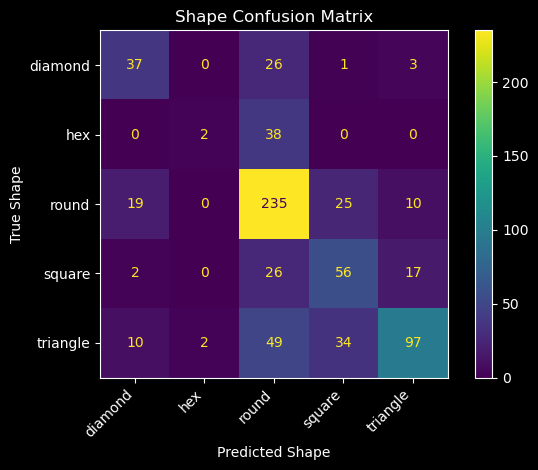

<Figure size 800x600 with 0 Axes>

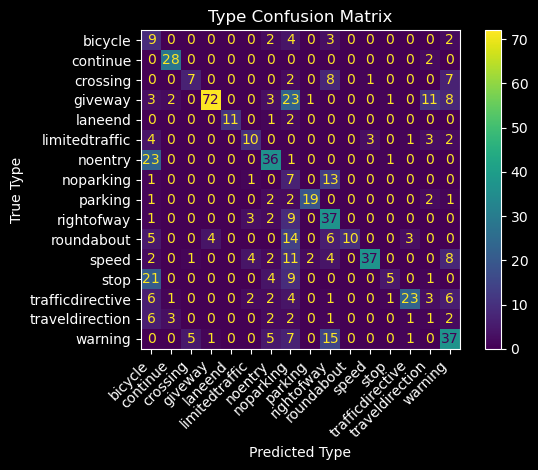

In [56]:
# Initialize empty lists to store the true labels and predicted labels
shape_true_labels = []
type_true_labels = []
shape_pred_labels = []
type_pred_labels = []

# Load and preprocess the test images
test_images = []
for image_path in test_df['image_path']:
    img = imageio.imread(image_path)
    img = img / 255.0
    test_images.append(img.flatten())

test_images = np.array(test_images)

# Get the true labels for the test images
test_shape_labels = test_df['shape_label'].values
test_type_labels = test_df['type_label'].values

# Generate predictions using the trained logistic regression classifiers
shape_preds = shape_classifier.predict(test_images)
type_preds = type_classifier.predict(test_images)

# Append the true labels and predicted labels to the lists
shape_true_labels.extend(test_shape_labels)
type_true_labels.extend(test_type_labels)
shape_pred_labels.extend(shape_preds)
type_pred_labels.extend(type_preds)

# Map the predicted labels back to their original names
shape_labels_map = {i: label for i, label in enumerate(shape_encoder.classes_)}
type_labels_map = {i: label for i, label in enumerate(type_encoder.classes_)}

# Create confusion matrices for shape and type
shape_cm = confusion_matrix(shape_true_labels, shape_pred_labels)
type_cm = confusion_matrix(type_true_labels, type_pred_labels)

print("Confusion matrices created.")

# Generate classification report for shape
print("Classification Report - Shape:")
print(classification_report(shape_true_labels, shape_pred_labels, target_names=shape_encoder.classes_))

# Generate classification report for type
print("Classification Report - Type:")
print(classification_report(type_true_labels, type_pred_labels, target_names=type_encoder.classes_))

# Plot the confusion matrix for shape
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot()
plt.title("Shape Confusion Matrix")
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot the confusion matrix for type
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot()
plt.title("Type Confusion Matrix")
plt.xlabel("Predicted Type")
plt.ylabel("True Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
discussion on results from logistic regression

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">X.0 Advanced Tuning</h1>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">X.1 Transfer Learning</h1>

In [ ]:
although it explicitly says not to use pre-trained models, Azadeh recommended creating a third Model utilizing advanced tuning such as Transfer Learning to increase the generalisability of our models as well as to improve, and make our models able to classify things outside of the initially trained domain. 
Azadeh suggested doing this in order to improve the likelihood of achieving a High Distinction (HD). 
Note: to evaluate the results from this new model you must go back, and re-use the previously run cells for evaluation. 

In [85]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df.iloc[train_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=(32, 32),  # Resize to (32, 32)
    batch_size=32,
    class_mode='multi_output'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df.iloc[val_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=(32, 32),  # Resize to (32, 32)
    batch_size=32,
    class_mode='multi_output'
)

Found 2959 validated image filenames.
Found 740 validated image filenames.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [86]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [87]:
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create the model architecture
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)

# Output layers for shape and type
shape_output = Dense(num_shape_classes, activation='softmax', name='shape')(x)
type_output = Dense(num_type_classes, activation='softmax', name='type')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=[shape_output, type_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'shape': 'sparse_categorical_crossentropy',
                    'type': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_indices) // 32,
    validation_data=val_generator,
    validation_steps=np.ceil(len(val_indices) / 32).astype(int),
    epochs=20
)

Epoch 1/20


2024-05-17 15:56:44.531321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - ETA: 0s - loss: 3.6319 - shape_loss: 1.1445 - type_loss: 2.3144 - shape_accuracy: 0.5702 - type_accuracy: 0.3184

2024-05-17 15:56:59.782042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - 19s 182ms/step - loss: 3.6319 - shape_loss: 1.1445 - type_loss: 2.3144 - shape_accuracy: 0.5702 - type_accuracy: 0.3184 - val_loss: 3.2367 - val_shape_loss: 1.1645 - val_type_loss: 2.0085 - val_shape_accuracy: 0.5054 - val_type_accuracy: 0.4122
Epoch 2/20
92/92 [==============================] - 16s 169ms/step - loss: 2.6759 - shape_loss: 0.8341 - type_loss: 1.7725 - shape_accuracy: 0.6949 - type_accuracy: 0.4633 - val_loss: 2.7393 - val_shape_loss: 0.8372 - val_type_loss: 1.8269 - val_shape_accuracy: 0.7189 - val_type_accuracy: 0.4500
Epoch 3/20
92/92 [==============================] - 16s 170ms/step - loss: 2.3117 - shape_loss: 0.7203 - type_loss: 1.5098 - shape_accuracy: 0.7468 - type_accuracy: 0.5360 - val_loss: 2.3645 - val_shape_loss: 0.8054 - val_type_loss: 1.4713 - val_shape_accuracy: 0.7081 - val_type_accuracy: 0.5689
Epoch 4/20
92/92 [==============================] - 16s 176ms/step - loss: 2.0311 - shape_loss: 0.6468 - type_loss: 1.29

In [ ]:
as observed Transfer Learning does X, we can now go back up to the Independent Evaluation to re-test our model noting we must covert our images to 30x30 since that is what the Transfer Learning's minimum size requirement is. We expect this to mess around with our results a little bit, but hopefully not too much. 

In [ ]:
It was suggested by Simon Jones to try U-Net Transfer Learning for our CNN.

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">X.0 Unsupervised Learning</h1>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">X.1 K-Means</h1>

In [3]:
# Function to load and preprocess images
def load_and_preprocess_image(path):
    img = Image.open(path).convert('L')  # Converts image to grayscale
    img = img.resize((28, 28))
    img_array = np.array(img)
    img_array = img_array.flatten()
    return img_array
    
# Load and preprocesses the images
image_paths = df['image_path'].values
X = np.array([load_and_preprocess_image(path) for path in image_paths])

# Scales the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Specify the number of clusters (k)
# k = 5  # simulate shape
k = 17  # simulate type

# Create and fit the k-means model
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

# Get the cluster labels for each image
labels = kmeans.labels_

# Print the number of images per cluster
cluster_sizes = [np.sum(labels == cluster_id) for cluster_id in range(k)]
print("Number of images per cluster:")

for cluster_id, size in enumerate(cluster_sizes):
    print(f"Cluster {cluster_id}: {size} images")

# Display 5 random images from each cluster
num_images_per_cluster = 5
num_cols = 5
num_rows = (k * num_images_per_cluster + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 2 * num_rows),
                         subplot_kw={'adjustable': 'box', 'aspect': 1})
axes = axes.ravel()

for cluster_id in range(k):
    cluster_images = [image_paths[i] for i in range(len(labels)) if labels[i] == cluster_id]
    for i, image_path in enumerate(np.random.choice(cluster_images, size=num_images_per_cluster, replace=False)):
        img = Image.open(image_path).convert('L')  # Converts images to grayscale
        axes[cluster_id * num_images_per_cluster + i].imshow(img, cmap='gray')
        if i == 0:
            axes[cluster_id * num_images_per_cluster + i].set_title(f"Cluster {cluster_id}")
        axes[cluster_id * num_images_per_cluster + i].axis('off')

# Remove any unused subplots
for i in range(k * num_images_per_cluster, len(axes)):
    axes[i].axis('off')
plt.tight_layout(pad=0.5, h_pad=0.1, w_pad=0.1)
plt.show()

NameError: name 'df' is not defined

<h5 style="color:#D2B4DE; margin-top: 20px;">
<ul>
  <li>Clustering Effectiveness:
    <ul>
      <li>The k-means clustering algorithm demonstrates its effectiveness in clustering similar images together which can help us determine the approximate number of classes within the dataset.</li>
      <li>The resulting clusters contain images that share similar shapes and mostly belonging to the same class (shape, and type), indicating the algorithm's ability to group related images together.</li>
    </ul>
  </li>
  <br>
  <li>Image Characteristics Influencing Clustering:
    <ul>
      <li>During the clustering process, k-means algorithms consider various image characteristics that we explored, such as pixel intensity and sharpness..</li>
      <li>Some of the generated clusters are based on these specific image properties, highlighting their importance in distinguishing between different classes of road signs. These definitively resulted in a few misclassified classes that are based on the pixel intensity (overall blackness or whiteness) or sharpess rather than the content of the images.</li>
    </ul>
  </li>
  <br>
  <li>Experimental Insights:
    <ul>
      <li>The additional experimentation conducted using the k-means algorithm provided valuable insights into alternative methodologies for accurately classifying road signs.</li>
      <li>By exploring the role of pixel intensity and sharpness in the clustering process, this experiment contributes to a deeper understanding of the factors influencing the correct categorization of road signs.</li>
    </ul>
  </li>
  <br>
  <li>Potential for Further Optimization:
    <ul>
      <li>While the k-means algorithm proves to be reasonably effective in clustering road sign images, there may be opportunities for further optimization.</li>
      <li>Fine-tuning the algorithm's parameters, such as the number of clusters or the distance metric used, could potentially enhance the accuracy and precision of the resulting clusters.</li>
    </ul>
  </li>
  <br>
  <li>Unsupervised Learning Approach:
    <ul>
      <li>In the absence of labelled training data, an unsupervised learning approach, such as k-means clustering, would have been a viable initial step.</li>
      <li>By applying unsupervised learning techniques, we could have created a model to uncover the underlying structure of the data if the dataset were larger, and less organised. This would help us determine the number of distinct classes based on shape and type.</li>
    </ul>
  </li>
</ul>
</h5>

In [126]:
# Print the current shape of X_val
print("Original shape of X_val:", X_val.shape)

# Reshape the input data to match the expected input shape of the model
num_samples = X_val.shape[0]
X_val_reshaped = X_val.reshape(num_samples, 28, 28)
X_val_reshaped = np.repeat(X_val_reshaped[..., np.newaxis], 3, axis=-1)

# Neural Network
shape_pred_nn = np.argmax(model.predict(X_val_reshaped)[0], axis=1)
type_pred_nn = np.argmax(model.predict(X_val_reshaped)[1], axis=1)

shape_acc_nn = accuracy_score(y_val_shape, shape_pred_nn)
shape_precision_nn = precision_score(y_val_shape, shape_pred_nn, average='weighted')
shape_recall_nn = recall_score(y_val_shape, shape_pred_nn, average='weighted')
shape_f1_nn = f1_score(y_val_shape, shape_pred_nn, average='weighted')

type_acc_nn = accuracy_score(y_val_type, type_pred_nn)
type_precision_nn = precision_score(y_val_type, type_pred_nn, average='weighted')
type_recall_nn = recall_score(y_val_type, type_pred_nn, average='weighted')
type_f1_nn = f1_score(y_val_type, type_pred_nn, average='weighted')

# Gradient Boosting
shape_pred_gb = shape_gb_best.predict(X_val)
type_pred_gb = type_gb_best.predict(X_val)

shape_acc_gb = accuracy_score(y_val_shape, shape_pred_gb)
shape_precision_gb = precision_score(y_val_shape, shape_pred_gb, average='weighted')
shape_recall_gb = recall_score(y_val_shape, shape_pred_gb, average='weighted')
shape_f1_gb = f1_score(y_val_shape, shape_pred_gb, average='weighted')

type_acc_gb = accuracy_score(y_val_type, type_pred_gb)
type_precision_gb = precision_score(y_val_type, type_pred_gb, average='weighted')
type_recall_gb = recall_score(y_val_type, type_pred_gb, average='weighted')
type_f1_gb = f1_score(y_val_type, type_pred_gb, average='weighted')

# Random Forest
shape_pred_rf = shape_rf_best.predict(X_val)
type_pred_rf = type_rf_best.predict(X_val)

shape_acc_rf = accuracy_score(y_val_shape, shape_pred_rf)
shape_precision_rf = precision_score(y_val_shape, shape_pred_rf, average='weighted')
shape_recall_rf = recall_score(y_val_shape, shape_pred_rf, average='weighted')
shape_f1_rf = f1_score(y_val_shape, shape_pred_rf, average='weighted')

type_acc_rf = accuracy_score(y_val_type, type_pred_rf)
type_precision_rf = precision_score(y_val_type, type_pred_rf, average='weighted')
type_recall_rf = recall_score(y_val_type, type_pred_rf, average='weighted')
type_f1_rf = f1_score(y_val_type, type_pred_rf, average='weighted')

# Decision Tree
shape_pred_dt = shape_dt_best.predict(X_val)
type_pred_dt = type_dt_best.predict(X_val)

shape_acc_dt = accuracy_score(y_val_shape, shape_pred_dt)
shape_precision_dt = precision_score(y_val_shape, shape_pred_dt, average='weighted')
shape_recall_dt = recall_score(y_val_shape, shape_pred_dt, average='weighted')
shape_f1_dt = f1_score(y_val_shape, shape_pred_dt, average='weighted')

type_acc_dt = accuracy_score(y_val_type, type_pred_dt)
type_precision_dt = precision_score(y_val_type, type_pred_dt, average='weighted')
type_recall_dt = recall_score(y_val_type, type_pred_dt, average='weighted')
type_f1_dt = f1_score(y_val_type, type_pred_dt, average='weighted')

# Create a list to store the evaluation metrics for each model
model_results = [
    ['Neural Network', shape_acc_nn, shape_precision_nn, shape_recall_nn, shape_f1_nn, type_acc_nn, type_precision_nn, type_recall_nn, type_f1_nn],
    ['Gradient Boosting', shape_acc_gb, shape_precision_gb, shape_recall_gb, shape_f1_gb, type_acc_gb, type_precision_gb, type_recall_gb, type_f1_gb],
    ['Random Forest', shape_acc_rf, shape_precision_rf, shape_recall_rf, shape_f1_rf, type_acc_rf, type_precision_rf, type_recall_rf, type_f1_rf],
    ['Decision Tree', shape_acc_dt, shape_precision_dt, shape_recall_dt, shape_f1_dt, type_acc_dt, type_precision_dt, type_recall_dt, type_f1_dt],
    ['Logistic Regression', shape_accuracy, shape_precision, shape_recall, shape_f1, type_accuracy, type_precision, type_recall, type_f1]
]

# Create a pandas DataFrame from the list
comparison_df = pd.DataFrame(model_results, columns=['Model', 'Shape Accuracy', 'Shape Precision', 'Shape Recall', 'Shape F1-score',
                                                     'Type Accuracy', 'Type Precision', 'Type Recall', 'Type F1-score'])

# Set the display options to show all columns in a single line
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Display the comparison table
print(comparison_df.to_string(index=False))

Original shape of X_val: (740, 784)
24/24 [==============================] - 0s 13ms/step
              Model  Shape Accuracy  Shape Precision  Shape Recall  Shape F1-score  Type Accuracy  Type Precision  Type Recall  Type F1-score
     Neural Network        0.995946         0.995990      0.995946        0.995958       0.993243        0.993356     0.993243       0.993224
  Gradient Boosting        0.960811         0.962547      0.960811        0.960089       0.950000        0.953086     0.950000       0.949127
      Random Forest        0.954054         0.956931      0.954054        0.952815       0.959459        0.961381     0.959459       0.958921
      Decision Tree        0.863514         0.867913      0.863514        0.864994       0.836486        0.844076     0.836486       0.837995
Logistic Regression        0.948649         0.949092      0.948649        0.948401       0.958108        0.960182     0.958108       0.958635


In [127]:
# Print the current shape of test_images
print("Original shape of test_images:", test_images.shape)

# Reshape the input data to match the expected input shape of the model
num_samples = test_images.shape[0]
test_images_reshaped = test_images.reshape(num_samples, -1)  # Flatten the images

# Neural Network
test_images_nn = test_images_reshaped.reshape(num_samples, 28, 28)
test_images_nn = np.repeat(test_images_nn[..., np.newaxis], 3, axis=-1)
shape_pred_nn = np.argmax(model.predict(test_images_nn)[0], axis=1)
type_pred_nn = np.argmax(model.predict(test_images_nn)[1], axis=1)

shape_acc_nn = accuracy_score(test_shape_labels, shape_pred_nn)
shape_precision_nn = precision_score(test_shape_labels, shape_pred_nn, average='weighted')
shape_recall_nn = recall_score(test_shape_labels, shape_pred_nn, average='weighted')
shape_f1_nn = f1_score(test_shape_labels, shape_pred_nn, average='weighted')

type_acc_nn = accuracy_score(test_type_labels, type_pred_nn)
type_precision_nn = precision_score(test_type_labels, type_pred_nn, average='weighted')
type_recall_nn = recall_score(test_type_labels, type_pred_nn, average='weighted')
type_f1_nn = f1_score(test_type_labels, type_pred_nn, average='weighted')

# Gradient Boosting
shape_pred_gb = shape_gb_best.predict(test_images_reshaped)
type_pred_gb = type_gb_best.predict(test_images_reshaped)

shape_acc_gb = accuracy_score(test_shape_labels, shape_pred_gb)
shape_precision_gb = precision_score(test_shape_labels, shape_pred_gb, average='weighted')
shape_recall_gb = recall_score(test_shape_labels, shape_pred_gb, average='weighted')
shape_f1_gb = f1_score(test_shape_labels, shape_pred_gb, average='weighted')

type_acc_gb = accuracy_score(test_type_labels, type_pred_gb)
type_precision_gb = precision_score(test_type_labels, type_pred_gb, average='weighted')
type_recall_gb = recall_score(test_type_labels, type_pred_gb, average='weighted')
type_f1_gb = f1_score(test_type_labels, type_pred_gb, average='weighted')

# Random Forest
shape_pred_rf = shape_rf_best.predict(test_images_reshaped)
type_pred_rf = type_rf_best.predict(test_images_reshaped)

shape_acc_rf = accuracy_score(test_shape_labels, shape_pred_rf)
shape_precision_rf = precision_score(test_shape_labels, shape_pred_rf, average='weighted')
shape_recall_rf = recall_score(test_shape_labels, shape_pred_rf, average='weighted')
shape_f1_rf = f1_score(test_shape_labels, shape_pred_rf, average='weighted')

type_acc_rf = accuracy_score(test_type_labels, type_pred_rf)
type_precision_rf = precision_score(test_type_labels, type_pred_rf, average='weighted')
type_recall_rf = recall_score(test_type_labels, type_pred_rf, average='weighted')
type_f1_rf = f1_score(test_type_labels, type_pred_rf, average='weighted')

# Decision Tree
shape_pred_dt = shape_dt_best.predict(test_images_reshaped)
type_pred_dt = type_dt_best.predict(test_images_reshaped)

shape_acc_dt = accuracy_score(test_shape_labels, shape_pred_dt)
shape_precision_dt = precision_score(test_shape_labels, shape_pred_dt, average='weighted')
shape_recall_dt = recall_score(test_shape_labels, shape_pred_dt, average='weighted')
shape_f1_dt = f1_score(test_shape_labels, shape_pred_dt, average='weighted')

type_acc_dt = accuracy_score(test_type_labels, type_pred_dt)
type_precision_dt = precision_score(test_type_labels, type_pred_dt, average='weighted')
type_recall_dt = recall_score(test_type_labels, type_pred_dt, average='weighted')
type_f1_dt = f1_score(test_type_labels, type_pred_dt, average='weighted')

# Logistic Regression
shape_pred_lr = shape_classifier.predict(test_images_reshaped)
type_pred_lr = type_classifier.predict(test_images_reshaped)

shape_acc_lr = accuracy_score(test_shape_labels, shape_pred_lr)
shape_precision_lr = precision_score(test_shape_labels, shape_pred_lr, average='weighted')
shape_recall_lr = recall_score(test_shape_labels, shape_pred_lr, average='weighted')
shape_f1_lr = f1_score(test_shape_labels, shape_pred_lr, average='weighted')

type_acc_lr = accuracy_score(test_type_labels, type_pred_lr)
type_precision_lr = precision_score(test_type_labels, type_pred_lr, average='weighted')
type_recall_lr = recall_score(test_type_labels, type_pred_lr, average='weighted')
type_f1_lr = f1_score(test_type_labels, type_pred_lr, average='weighted')

# Create a list to store the evaluation metrics for each model
model_results = [
    ['Neural Network', shape_acc_nn, shape_precision_nn, shape_recall_nn, shape_f1_nn, type_acc_nn, type_precision_nn, type_recall_nn, type_f1_nn],
    ['Gradient Boosting', shape_acc_gb, shape_precision_gb, shape_recall_gb, shape_f1_gb, type_acc_gb, type_precision_gb, type_recall_gb, type_f1_gb],
    ['Random Forest', shape_acc_rf, shape_precision_rf, shape_recall_rf, shape_f1_rf, type_acc_rf, type_precision_rf, type_recall_rf, type_f1_rf],
    ['Decision Tree', shape_acc_dt, shape_precision_dt, shape_recall_dt, shape_f1_dt, type_acc_dt, type_precision_dt, type_recall_dt, type_f1_dt],
    ['Logistic Regression', shape_acc_lr, shape_precision_lr, shape_recall_lr, shape_f1_lr, type_acc_lr, type_precision_lr, type_recall_lr, type_f1_lr]
]

# Create a pandas DataFrame from the list
comparison_df = pd.DataFrame(model_results, columns=['Model', 'Shape Accuracy', 'Shape Precision', 'Shape Recall', 'Shape F1-score',
                                                     'Type Accuracy', 'Type Precision', 'Type Recall', 'Type F1-score'])

# Set the display options to show all columns in a single line
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Display the comparison table
print(comparison_df.to_string(index=False))

Original shape of test_images: (689, 28, 28)
22/22 [==============================] - 0s 11ms/step
              Model  Shape Accuracy  Shape Precision  Shape Recall  Shape F1-score  Type Accuracy  Type Precision  Type Recall  Type F1-score
     Neural Network        0.831640         0.840136      0.831640        0.828229       0.789550        0.853413     0.789550       0.795717
  Gradient Boosting        0.698113         0.693441      0.698113        0.665543       0.500726        0.656473     0.500726       0.526417
      Random Forest        0.699565         0.701655      0.699565        0.661380       0.542816        0.658558     0.542816       0.551518
      Decision Tree        0.592163         0.580335      0.592163        0.573428       0.394775        0.446641     0.394775       0.404959
Logistic Regression        0.619739         0.629102      0.619739        0.601057       0.506531        0.684012     0.506531       0.545015
